In [ ]:
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
from xgboost import XGBClassifier,callback
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,accuracy_score,brier_score_loss,f1_score, roc_curve
from sklearn.calibration import calibration_curve,CalibratedClassifierCV
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, label_binarize, MinMaxScaler,StandardScaler
import warnings
import yfinance as yf
from scipy.stats import uniform, randint
import ta
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.isotonic import IsotonicRegression
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE
from functools import reduce
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import grangercausalitytests,coint
from hmmlearn.hmm import GaussianHMM
from ta.momentum import RSIIndicator
from ta.trend import MACD, ADXIndicator
from ta.volatility import BollingerBands
from fredapi import Fred
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

In [ ]:
# FRED API  
fred = Fred(api_key=' ')

fred_series = {
    'Unemployment': 'UNRATE',
    'CPI': 'CPIAUCSL',
    'FedFunds': 'FEDFUNDS',
    'M2': 'M2SL',
    'GS10': 'GS10',
    'GS2': 'GS2',
    'TED': 'TEDRATE',
    'Sentiment': 'UMCSENT',
    'IP_Manufact': 'IPMAN',
    'RetailSales': 'RSXFS'
}

macro_frames = []
for name, code in fred_series.items():
    try:
        s = fred.get_series(code, observation_start='2015-01-01')
        macro_frames.append(s.rename(name).to_frame())
    except Exception as e:
        print(f"Failed to download {name} ({code}): {e}")

macro_df = pd.concat(macro_frames, axis=1)
macro_df.index = pd.to_datetime(macro_df.index)

# Daily Calender and forward-fill
full_macro_idx = pd.date_range(macro_df.index.min(), macro_df.index.max(), freq='D')
macro_df = macro_df.reindex(full_macro_idx).ffill()

In [3]:
tickers = {
    "Gold": "GC=F", "Silver": "SI=F", "Platinum": "PL=F", "Palladium": "PA=F", "Copper": "HG=F",
    "Crude": "CL=F", "NaturalGas": "NG=F", "Dollar": "DX-Y.NYB", "EURUSD": "EURUSD=X", "JPY": "JPY=X",
    "CHF": "CHF=X", "SP500": "^GSPC", "NASDAQ": "^IXIC", "EM_Index": "EEM", "China_ETF": "FXI",
    "10Y_Yield": "^TNX", "30Y_Yield": "^TYX", "VIX": "^VIX", "MOVE": "^MOVE",
    "GoldETF": "GLD", "GoldMinersETF": "GDX", "Newmont": "NEM", "Sibanye": "SBSW",
    "Bitcoin": "BTC-USD", "Ethereum": "ETH-USD", "Wheat": "ZW=F", "Corn": "ZC=F", "Soybeans": "ZS=F",
    "ARKG": "ARKG", "LQD": "LQD", "HYG": "HYG", "OVX": "^OVX", "GVZ": "^GVZ",
    "IRX": "^IRX", "FVX": "^FVX", "TIP": "TIP"
}

data = {}
for name, ticker in tickers.items():
    df = yf.download(ticker, start='2015-01-01', end='2025-08-01',
                     progress=False, group_by='column', auto_adjust=False)

    if df.empty:
        print(f"⚠️ No data for {name} ({ticker})")
        continue

    # --- MultiIndex---
    
    if isinstance(df.columns, pd.MultiIndex):
        
        try:
            lvl1 = df.columns.get_level_values(1)
            if len(set(lvl1)) == 1:
                df.columns = df.columns.get_level_values(0)
            else:
                # Farklıysa iki seviyeyi birleştir
                df.columns = ['_'.join(map(str, c)).strip('_') for c in df.columns]
        except Exception:
            # Her ihtimale karşı düzle
            df.columns = ['_'.join(map(str, c)).strip('_') for c in df.columns]

    # ---  ---
    if name == "Gold":
        df = df[['Close', 'High', 'Low', 'Volume']].rename(columns={
            'Close':  'Gold_GC=F',
            'High':   'Gold_High_GC=F',
            'Low':    'Gold_Low_GC=F',
            'Volume': 'Gold_Vol_GC=F'
        })
    else:
        df = df[['Close']].rename(columns={'Close': f'{name}_{ticker}'})

    data[name] = df

if "Gold" in data:
    print("Gold cols ->", list(data["Gold"].columns))
else:
    raise RuntimeError("Gold verisi indirilemedi (data['Gold'] yok).")

Gold cols -> ['Gold_GC=F', 'Gold_High_GC=F', 'Gold_Low_GC=F', 'Gold_Vol_GC=F']


In [4]:
market_df = reduce(lambda L, R: L.join(R, how='outer'), data.values()).sort_index()


if isinstance(market_df.columns, pd.MultiIndex):
    market_df.columns = ['_'.join([str(x) for x in tup if str(x) != '']).strip('_')
                         for tup in market_df.columns]

# Günlük takvime oturt ve forward-fill
full_market_idx = pd.date_range(market_df.index.min(), market_df.index.max(), freq='D')
market_df = market_df.reindex(full_market_idx).ffill()

# Adding weekends also as daily data with same as last closure
vol_cols = [c for c in market_df.columns if c.endswith(('_Vol', '_Volume'))]
mask_new = ~market_df.index.isin(data["Gold"].index)  # Gold veri günleri referans
if vol_cols:
    market_df.loc[mask_new, vol_cols] = 0

# =======================
# 4) Comman End date
# =======================
end_date = min(market_df.index.max(), macro_df.index.max())
market_df = market_df.loc[:end_date]
macro_df = macro_df.loc[:end_date]

# =======================
# 5) Merge
# =======================
merged_df = market_df.join(macro_df, how='left')

if 'Gold_GC=F' not in merged_df.columns:
    raise ValueError("Gold_GC=F kolonu bulunamadı, download kısmını kontrol et!")

merged_df = merged_df[merged_df['Gold_GC=F'].notna()].copy()
merged_df = merged_df.reset_index().rename(columns={'index': 'Date'})
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

print("✅ Merged dataset ready.")
print("Shape:", merged_df.shape)
print("Columns example:", merged_df.columns[:10])
print("Date range:", merged_df['Date'].min(), "→", merged_df['Date'].max())

✅ Merged dataset ready.
Shape: (3834, 50)
Columns example: Index(['Date', 'Gold_GC=F', 'Gold_High_GC=F', 'Gold_Low_GC=F', 'Gold_Vol_GC=F',
       'Silver_SI=F', 'Platinum_PL=F', 'Palladium_PA=F', 'Copper_HG=F',
       'Crude_CL=F'],
      dtype='object')
Date range: 2015-01-02 00:00:00 → 2025-07-01 00:00:00


In [5]:
def engineer_features(df):
    import numpy as np
    import pandas as pd
    import ta

    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    gold      = 'Gold_GC=F'
    gold_high = 'Gold_High_GC=F'
    gold_low  = 'Gold_Low_GC=F'
    gold_vol  = 'Gold_Vol_GC=F'

    assets = [
        gold, 'Silver_SI=F', 'Platinum_PL=F', 'Palladium_PA=F', 'Copper_HG=F',
        'Crude_CL=F', 'NaturalGas_NG=F', 'Dollar_DX-Y.NYB', 'EURUSD_EURUSD=X',
        'JPY_JPY=X', 'CHF_CHF=X', 'SP500_^GSPC', 'NASDAQ_^IXIC', 'EM_Index_EEM',
        'China_ETF_FXI', '10Y_Yield_^TNX', '30Y_Yield_^TYX', 'VIX_^VIX',
        'MOVE_^MOVE', 'GoldETF_GLD', 'GoldMinersETF_GDX', 'Newmont_NEM',
        'Sibanye_SBSW', 'Bitcoin_BTC-USD', 'Ethereum_ETH-USD', 'Wheat_ZW=F',
        'Corn_ZC=F', 'Soybeans_ZS=F', 'ARKG_ARKG', 'LQD_LQD', 'HYG_HYG',
        'OVX_^OVX', 'GVZ_^GVZ', 'IRX_^IRX', 'FVX_^FVX', 'TIP_TIP'
    ]

    # Gold Ratio
    for asset in assets:
        if asset != gold and all(c in df.columns for c in [gold, asset]):
            df[f'Gold_to_{asset}'] = df[gold] / df[asset]

    # Laglar
    for lag in [1, 2, 3]:
        for asset in [gold, 'Crude_CL=F', 'Dollar_DX-Y.NYB', 'Silver_SI=F', 'Bitcoin_BTC-USD']:
            if asset in df.columns:
                df[f'{asset}_lag_{lag}'] = df[asset].shift(lag)

    # Rolling Statistics
    for w in [5, 10, 20]:
        for asset in [gold, 'Silver_SI=F', 'Crude_CL=F', 'Bitcoin_BTC-USD']:
            if asset in df.columns:
                df[f'{asset}_SMA_{w}'] = df[asset].rolling(w).mean()
                df[f'{asset}_STD_{w}'] = df[asset].rolling(w).std()

    
    try:
        df['Gold_RSI'] = ta.momentum.RSIIndicator(close=df[gold]).rsi()
    except Exception:
        df['Gold_RSI'] = np.nan
    try:
        df['Gold_MACD'] = ta.trend.MACD(close=df[gold]).macd_diff()
    except Exception:
        df['Gold_MACD'] = np.nan
    try:
        df['Gold_BB_width'] = ta.volatility.BollingerBands(close=df[gold]).bollinger_wband()
    except Exception:
        df['Gold_BB_width'] = np.nan
    try:
        if all(c in df.columns for c in [gold_high, gold_low, gold]):
            df['Gold_ADX'] = ta.trend.ADXIndicator(
                high=df[gold_high], low=df[gold_low], close=df[gold]
            ).adx()
        else:
            df['Gold_ADX'] = np.nan
    except Exception:
        df['Gold_ADX'] = np.nan

    try:
        if all(c in df.columns for c in [gold_high, gold_low, gold, gold_vol]):
            df['Gold_MFI'] = ta.volume.MFIIndicator(
                high=df[gold_high], low=df[gold_low], close=df[gold], volume=df[gold_vol]
            ).money_flow_index()
        else:
            df['Gold_MFI'] = np.nan
    except Exception:
        df['Gold_MFI'] = np.nan

    #  (5 days forward)
    df['Gold_5day_ret'] = df[gold].shift(-5) - df[gold]
    df['Gold_target']   = (df['Gold_5day_ret'] > 0).astype(int)

    df = df[df['Gold_target'].notna()]

    return df.reset_index()


In [6]:
def add_advanced_features(df):
    import numpy as np
    import pandas as pd
    import ta

    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    gold   = 'Gold_GC=F'
    silver = 'Silver_SI=F'
    vix    = 'VIX_^VIX'
    dollar = 'Dollar_DX-Y.NYB'

    candidate_cols = [
        gold, silver, 'Platinum_PL=F', 'Palladium_PA=F', 'Copper_HG=F',
        'NaturalGas_NG=F', 'Crude_CL=F', dollar, 'EURUSD_EURUSD=X', 'JPY_JPY=X',
        'CHF_CHF=X', 'SP500_^GSPC', 'NASDAQ_^IXIC', 'EM_Index_EEM', 'China_ETF_FXI',
        '10Y_Yield_^TNX', '30Y_Yield_^TYX', vix, 'MOVE_^MOVE', 'GoldETF_GLD',
        'GoldMinersETF_GDX', 'Newmont_NEM', 'Sibanye_SBSW', 'Bitcoin_BTC-USD',
        'Ethereum_ETH-USD', 'Wheat_ZW=F', 'Corn_ZC=F', 'Soybeans_ZS=F',
        'ARKG_ARKG', 'LQD_LQD', 'HYG_HYG', 'OVX_^OVX', 'GVZ_^GVZ', 'IRX_^IRX',
        'FVX_^FVX', 'TIP_TIP'
    ]
    assets = [c for c in candidate_cols if c in df.columns]

    # Momentum / Z / Sharpe (20d) — inf cleaning
    for a in assets:
        m = df[a].pct_change()
        mean = m.rolling(20).mean()
        std  = m.rolling(20).std()
        df[f'{a}_momentum'] = m
        df[f'{a}_zscore']    = (m - mean) / std
        sharpe = mean / std
        df[f'{a}_Sharpe_20'] = sharpe.replace([np.inf, -np.inf], np.nan)

    # Gold ile rolling korelasyonlar
    if gold in df.columns:
        for a in assets:
            if a != gold and a in df.columns:
                df[f'corr_{gold}_{a}'] = df[gold].rolling(20).corr(df[a])


    try:
        df['Gold_BB_squeeze'] = ta.volatility.BollingerBands(close=df[gold]).bollinger_wband()
    except Exception:
        df['Gold_BB_squeeze'] = np.nan

    df['Gold_volatility_20d'] = df[gold].pct_change().rolling(20).std()

    if dollar in df.columns:
        df['DXY_momentum_5d']  = df[dollar].pct_change(5)
        df['DXY_momentum_20d'] = df[dollar].pct_change(20)

    # Gold-Silver spread / z / ratio
    if gold in df.columns and silver in df.columns:
        spread = df[gold] - df[silver]
        df['Gold_Silver_spread'] = spread
        mu, sd = spread.rolling(20).mean(), spread.rolling(20).std()
        df['Gold_Silver_z'] = (spread - mu) / sd
        df[f'Gold_to_{silver}'] = df[gold] / df[silver]

    if 'Gold_target' in df.columns:
        df = df[df['Gold_target'].notna()]

    return df.reset_index()


In [7]:
features_df = engineer_features(merged_df)
final_df = add_advanced_features(features_df)

In [8]:
final_df.shape

(3834, 280)

In [9]:
print(final_df.shape)
print(final_df.columns[-10:])

(3834, 280)
Index(['corr_Gold_GC=F_GVZ_^GVZ', 'corr_Gold_GC=F_IRX_^IRX',
       'corr_Gold_GC=F_FVX_^FVX', 'corr_Gold_GC=F_TIP_TIP', 'Gold_BB_squeeze',
       'Gold_volatility_20d', 'DXY_momentum_5d', 'DXY_momentum_20d',
       'Gold_Silver_spread', 'Gold_Silver_z'],
      dtype='object')


In [10]:
print(final_df.columns[:12])
print(final_df.isna().mean().sort_values(ascending=False).head(10))
print(final_df[['Date','Gold_GC=F','Gold_target']].head())

Index(['Date', 'Gold_GC=F', 'Gold_High_GC=F', 'Gold_Low_GC=F', 'Gold_Vol_GC=F',
       'Silver_SI=F', 'Platinum_PL=F', 'Palladium_PA=F', 'Copper_HG=F',
       'Crude_CL=F', 'NaturalGas_NG=F', 'Dollar_DX-Y.NYB'],
      dtype='object')
Ethereum_ETH-USD_Sharpe_20         0.276995
Ethereum_ETH-USD_zscore            0.276995
corr_Gold_GC=F_Ethereum_ETH-USD    0.276734
Ethereum_ETH-USD_momentum          0.272040
Ethereum_ETH-USD                   0.271779
Gold_to_Ethereum_ETH-USD           0.271779
Gold_MACD                          0.008607
GVZ_^GVZ_Sharpe_20                 0.005216
HYG_HYG_Sharpe_20                  0.005216
OVX_^OVX_zscore                    0.005216
dtype: float64
        Date    Gold_GC=F  Gold_target
0 2015-01-02  1186.000000            1
1 2015-01-03  1186.000000            1
2 2015-01-04  1186.000000            1
3 2015-01-05  1203.900024            1
4 2015-01-06  1219.300049            0


--------

In [11]:
## 1) (Oprsional) HMM regime extraction

USE_HMM = True 

if USE_HMM:
    import numpy as np, pandas as pd
    from hmmlearn.hmm import GaussianHMM

    def add_hmm_regimes(final_df, n_states_grid=(2,3,4), roll_mode=5):
        df = final_df.copy()
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)

        feats = {}
        feats['ret1']   = df['Gold_GC=F'].pct_change()
        feats['vol20']  = feats['ret1'].rolling(20).std()
        if 'VIX_^VIX' in df.columns:
            feats['vix'] = df['VIX_^VIX'].pct_change().fillna(0)
        if 'Dollar_DX-Y.NYB' in df.columns:
            feats['dxy_m20'] = df['Dollar_DX-Y.NYB'].pct_change(20)
        if 'Gold_RSI' in df.columns:
            feats['rsi'] = (df['Gold_RSI'] - 50)/50.0

        X = pd.concat(feats, axis=1).dropna()
        Xz = (X - X.mean())/X.std(ddof=0)
        Xz = Xz.replace([np.inf, -np.inf], np.nan).dropna()

        best = None
        for k in n_states_grid:
            try:
                hmm = GaussianHMM(n_components=k, covariance_type='diag', n_iter=200, random_state=42)
                hmm.fit(Xz.values)
                ll = hmm.score(Xz.values)
                p = k*Xz.shape[1]*2 + (k-1) + k*(k-1)
                bic = -2*ll + p*np.log(len(Xz))
                if (best is None) or (bic < best[0]):
                    best = (bic, hmm, k)
            except Exception:
                continue

        _, hmm, k = best
        states = pd.Series(hmm.predict(Xz.values), index=Xz.index, name='RegimeRaw')

        tmp = pd.concat([states, X['ret1'], X['vol20']], axis=1).dropna()
        lab = tmp.groupby('RegimeRaw').agg(mu_ret=('ret1','mean'), vol=('vol20','mean'))

        mapping = {}
        if k == 2:
            ridx = lab.sort_values(['mu_ret']).index.tolist()
            mapping[ridx[1]] = 0  # Risk-On
            mapping[ridx[0]] = 1  # Risk-Off
        else:
            vol_rank = lab.sort_values('vol').index.tolist()
            low, mid, high = vol_rank[0], vol_rank[1], vol_rank[-1]
            mapping[low]  = 0  # Risk-On
            mapping[mid]  = 1  # Risk-Off
            mapping[high] = 2  # Crisis

        regimes = states.map(mapping).to_frame('Regime').reindex(df.index)
        regimes['Regime'] = regimes['Regime'].fillna(method='ffill')
        regimes['RegimeSm'] = regimes['Regime'].rolling(5, min_periods=1)\
                                              .apply(lambda x: x.value_counts().index[0])

        out = df.copy()
        out[['Regime','RegimeSm']] = regimes[['Regime','RegimeSm']]
        out = out.reset_index()
        out[['Regime_0','Regime_1','Regime_2']] = pd.get_dummies(out['RegimeSm']).reindex(columns=[0,1,2], fill_value=0)
        return out

    final_df = add_hmm_regimes(final_df)

In [12]:
# 2) Model matrix No cointegration included in this lag of project
# ===========================
def build_model_matrix(final_df,
                       horizon_days=10,
                       margin_eps=0.003,
                       drop_crypto=True,
                       engineered_only=True,
                       max_nan_frac=0.20,
                       macro_lag_bdays=5):
    import numpy as np, pandas as pd
    df = final_df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)

    macro_cols = ['Unemployment','CPI','FedFunds','M2','GS10','GS2','TED',
                  'Sentiment','IP_Manufact','RetailSales']
    if macro_lag_bdays > 0:
        df = df.set_index('Date')
        for c in macro_cols:
            if c in df.columns:
                df[c] = df[c].shift(macro_lag_bdays)
        df = df.reset_index().rename(columns={'index':'Date'})

    gold = 'Gold_GC=F'
    df['ret_h']  = df[gold].shift(-horizon_days)/df[gold] - 1.0
    df['label']  = np.where(df['ret_h'] >  margin_eps, 1,
                    np.where(df['ret_h'] < -margin_eps, 0, np.nan))
    df = df[df['label'].notna()].copy()

    if engineered_only:
        drop_cols = [
            gold,'Gold_High_GC=F','Gold_Low_GC=F','Gold_Vol_GC=F',
            'Silver_SI=F','Platinum_PL=F','Palladium_PA=F','Copper_HG=F',
            'Crude_CL=F','NaturalGas_NG=F','Dollar_DX-Y.NYB','EURUSD_EURUSD=X',
            'JPY_JPY=X','CHF_CHF=X','SP500_^GSPC','NASDAQ_^IXIC','EM_Index_EEM',
            'China_ETF_FXI','10Y_Yield_^TNX','30Y_Yield_^TYX','VIX_^VIX','MOVE_^MOVE',
            'GoldETF_GLD','GoldMinersETF_GDX','Newmont_NEM','Sibanye_SBSW',
            'Bitcoin_BTC-USD','Ethereum_ETH-USD','Wheat_ZW=F','Corn_ZC=F','Soybeans_ZS=F',
            'ARKG_ARKG','LQD_LQD','HYG_HYG','OVX_^OVX','GVZ_^GVZ','IRX_^IRX','FVX_^FVX','TIP_TIP',
            'Unemployment','CPI','FedFunds','M2','GS10','GS2','TED','Sentiment','IP_Manufact','RetailSales',
            'Gold_target','Gold_5day_ret','ret_h','label'
        ]
        X = df.drop(columns=[c for c in drop_cols if c in df.columns] + ['Date'])
    else:
        X = df.drop(columns=['Gold_target','Gold_5day_ret','ret_h','label','Date'])

    y = df['label'].astype(int)
    if drop_crypto:
        X = X[[c for c in X.columns if 'Bitcoin_BTC-USD' not in c and 'Ethereum_ETH-USD' not in c]]

    X = X.loc[:, X.isna().mean() <= max_nan_frac]
    med = X.median()
    X  = X.fillna(med)
    return X, y, df['Date']

X_all, y_all, dates_all = build_model_matrix(
    final_df,
    horizon_days=10,      # 10 veya 20 days can be tried 
    margin_eps=0.003,     # 0.002–0.004 small interval grid
    drop_crypto=True,
    engineered_only=True,
    max_nan_frac=0.20,
    macro_lag_bdays=5
)

In [14]:
## 3) Walk-forward + XGBoost + Calibration + Quantile 
# ===========================
import numpy as np, pandas as pd, xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve
from sklearn.linear_model import LogisticRegression

def walk_forward_masks_flex(dates,
                            train_years=5, valid_months=6, test_months=6,
                            step_months=3, expand=True):
    dates = pd.to_datetime(dates)
    start, end = dates.min(), dates.max()
    folds = []
    anchor = start
    cursor = start
    while True:
        train_start = anchor if expand else cursor
        train_end   = cursor + pd.DateOffset(years=train_years)
        valid_end   = train_end + pd.DateOffset(months=valid_months)
        test_end    = valid_end + pd.DateOffset(months=test_months)
        if test_end > end:
            break
        mtr = (dates > train_start) & (dates <= train_end)
        mva = (dates > train_end)   & (dates <= valid_end)
        mte = (dates > valid_end)   & (dates <= test_end)
        if mtr.sum() and mva.sum() and mte.sum():
            folds.append((mtr, mva, mte, train_end, valid_end, test_end))
        cursor = cursor + pd.DateOffset(months=step_months)
    return folds

def calibrate_probs(p_val, y_val, p_test):
    lr = LogisticRegression(solver='lbfgs')
    lr.fit(p_val.reshape(-1,1), y_val.astype(int))
    return lr.predict_proba(p_test.reshape(-1,1))[:,1]

def select_threshold(y_val, p_val, method='quantile'):
    y_val = np.asarray(y_val).astype(int); p_val = np.asarray(p_val)
    if method == 'youden':
        fpr, tpr, thr = roc_curve(y_val, p_val)
        return float(thr[np.argmax(tpr - fpr)])
    elif method == 'f1':
        grid = np.linspace(0.15, 0.85, 71)
        f1s = [f1_score(y_val, (p_val >= t).astype(int)) for t in grid]
        return float(grid[int(np.argmax(f1s))])
    elif method == 'quantile':
        q = float(np.mean(y_val))  
        return float(np.quantile(p_val, 1 - q))
    return 0.5

folds = walk_forward_masks_flex(dates_all, train_years=5, valid_months=6, test_months=6, step_months=6,expand=True)

print(f"{len(folds)} fold created.")

threshold_method = 'quantile'  # : quantile

results, all_test_p, all_test_y = [], [], []
for i, (mtr, mva, mte, tr_end, va_end, te_end) in enumerate(folds, 1):
    X_tr, y_tr = X_all[mtr], y_all[mtr]
    X_va, y_va = X_all[mva], y_all[mva]
    X_te, y_te = X_all[mte], y_all[mte]

    med = X_tr.median()
    X_tr = X_tr.fillna(med); X_va = X_va.fillna(med); X_te = X_te.fillna(med)

    dtrain = xgb.DMatrix(X_tr.astype(np.float32), label=y_tr.astype(np.int32))
    dvalid = xgb.DMatrix(X_va.astype(np.float32), label=y_va.astype(np.int32))
    dtest  = xgb.DMatrix(X_te.astype(np.float32))

    pos = int((y_tr == 1).sum()); neg = int((y_tr == 0).sum())
    spw = max(1.0, neg / max(1, pos))

    params = {
        "max_depth": 5, "eta": 0.03, "min_child_weight": 5,
        "subsample": 0.8, "colsample_bytree": 0.8,
        "objective": "binary:logistic", "eval_metric": "auc",
        "tree_method": "hist", "scale_pos_weight": spw
    }

    bst = xgb.train(params, dtrain, num_boost_round=3000,
                    evals=[(dtrain,"train"), (dvalid,"valid")],
                    early_stopping_rounds=100, verbose_eval=False)

    try:
        p_va = bst.predict(dvalid, iteration_range=(0, bst.best_iteration + 1))
        p_te = bst.predict(dtest,  iteration_range=(0, bst.best_iteration + 1))
    except TypeError:
        p_va = bst.predict(dvalid, ntree_limit=getattr(bst, "best_ntree_limit", bst.best_iteration + 1))
        p_te = bst.predict(dtest,  ntree_limit=getattr(bst, "best_ntree_limit",  bst.best_iteration + 1))

    p_va_cal = calibrate_probs(p_va.reshape(-1,1), y_va.values, p_va.reshape(-1,1))
    p_te_cal = calibrate_probs(p_va.reshape(-1,1), y_va.values, p_te.reshape(-1,1))
    thr_star = select_threshold(y_va, p_va_cal, method=threshold_method)
    yhat_te  = (p_te_cal >= thr_star).astype(int)

    pr_tr = float(y_tr.mean()); pr_va = float(y_va.mean()); pr_te = float(y_te.mean()); pr_hat = float(yhat_te.mean())
    auc_v = float(getattr(bst, "best_score", roc_auc_score(y_va, p_va)))
    auc_t = roc_auc_score(y_te, p_te)
    acc_t = accuracy_score(y_te, yhat_te)
    f1_t  = f1_score(y_te, yhat_te)

    print(f"Fold {i:02d} | train≤{tr_end.date()} valid≤{va_end.date()} test≤{te_end.date()} "
          f"| AUCv={auc_v:.3f} AUCt={auc_t:.3f} thr={thr_star:.3f} "
          f"| ACC={acc_t:.3f} F1={f1_t:.3f} "
          f"| pos_rate tr/va/te={pr_tr:.2f}/{pr_va:.2f}/{pr_te:.2f} pred_pos={pr_hat:.2f}")

    results.append({
        "fold": i, "train_end": tr_end, "valid_end": va_end, "test_end": te_end,
        "valid_auc": auc_v, "test_auc": auc_t, "acc": acc_t, "f1": f1_t,
        "thr": thr_star, "pos_tr": pr_tr, "pos_va": pr_va, "pos_te": pr_te, "pos_hat": pr_hat
    })

    all_test_p.append(pd.Series(p_te_cal, index=X_te.index))
    all_test_y.append(pd.Series(y_te.values, index=X_te.index))

res_df = pd.DataFrame(results).sort_values("fold")
print("\nSummary:")
print(res_df[['fold','train_end','valid_end','test_end','valid_auc','test_auc','acc','f1','pos_te','pos_hat']].head(20))

all_test_p = pd.concat(all_test_p).sort_index()
all_test_y = pd.concat(all_test_y).sort_index()
print("\nGeneral Test AUC:", roc_auc_score(all_test_y, all_test_p))

9 fold created.
Fold 01 | train≤2020-01-02 valid≤2020-07-02 test≤2021-01-02 | AUCv=0.705 AUCt=0.626 thr=0.589 | ACC=0.574 F1=0.511 | pos_rate tr/va/te=0.54/0.66/0.56 pred_pos=0.31
Fold 02 | train≤2020-07-02 valid≤2021-01-02 test≤2021-07-02 | AUCv=0.608 AUCt=0.360 thr=0.545 | ACC=0.484 F1=0.640 | pos_rate tr/va/te=0.55/0.56/0.52 pred_pos=0.91
Fold 03 | train≤2021-01-02 valid≤2021-07-02 test≤2022-01-02 | AUCv=0.587 AUCt=0.413 thr=0.522 | ACC=0.474 F1=0.582 | pos_rate tr/va/te=0.55/0.52/0.57 pred_pos=0.69
Fold 04 | train≤2021-07-02 valid≤2022-01-02 test≤2022-07-02 | AUCv=0.483 AUCt=0.659 thr=0.571 | ACC=0.366 F1=0.440 | pos_rate tr/va/te=0.55/0.57/0.48 pred_pos=0.65
Fold 05 | train≤2022-01-02 valid≤2022-07-02 test≤2023-01-02 | AUCv=0.541 AUCt=0.449 thr=0.478 | ACC=0.456 F1=0.324 | pos_rate tr/va/te=0.55/0.48/0.53 pred_pos=0.28
Fold 06 | train≤2022-07-02 valid≤2023-01-02 test≤2023-07-02 | AUCv=0.644 AUCt=0.397 thr=0.527 | ACC=0.382 F1=0.254 | pos_rate tr/va/te=0.54/0.53/0.48 pred_pos=0.35


In [15]:
def walk_forward_masks_flex(dates,
                            train_years=5, valid_months=6, test_months=6,
                            step_months=3, expand=True):
    dates = pd.to_datetime(dates)
    start, end = dates.min(), dates.max()
    folds = []
    anchor = start
    cursor = start
    while True:
        train_start = anchor if expand else cursor
        train_end   = cursor + pd.DateOffset(years=train_years)
        valid_end   = train_end + pd.DateOffset(months=valid_months)
        test_end    = valid_end + pd.DateOffset(months=test_months)
        if test_end > end:
            break
        mtr = (dates > train_start) & (dates <= train_end)
        mva = (dates > train_end)   & (dates <= valid_end)
        mte = (dates > valid_end)   & (dates <= test_end)
        if mtr.sum() and mva.sum() and mte.sum():
            folds.append((mtr, mva, mte, train_end, valid_end, test_end))
        cursor = cursor + pd.DateOffset(months=step_months)
    return folds

def calibrate_probs(p_val, y_val, p_test):

    lr = LogisticRegression(solver='lbfgs', max_iter=1000)
    lr.fit(p_val.reshape(-1,1), y_val.astype(int))
    return lr.predict_proba(p_test.reshape(-1,1))[:,1]

def select_threshold(y_val, p_val, method='quantile'):

    y_val = np.asarray(y_val).astype(int); p_val = np.asarray(p_val)
    if method == 'youden':
        fpr, tpr, thr = roc_curve(y_val, p_val)
        return float(thr[np.argmax(tpr - fpr)])
    elif method == 'f1':
        grid = np.linspace(0.15, 0.85, 71)
        f1s = [f1_score(y_val, (p_val >= t).astype(int)) for t in grid]
        return float(grid[int(np.argmax(f1s))])
    elif method == 'quantile':
        q = float(np.mean(y_val))  
        return float(np.quantile(p_val, 1 - q))
    return 0.5

In [ ]:
# 2) Walk-forward Calibration
# ===============================
import numpy as np, pandas as pd, xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve
from sklearn.linear_model import LogisticRegression

def calibrate_probs(p_val, y_val, p_test):
    lr = LogisticRegression(solver='lbfgs', max_iter=1000)
    lr.fit(p_val.reshape(-1,1), y_val.astype(int))
    return lr.predict_proba(p_test.reshape(-1,1))[:,1]

def select_threshold(y_val, p_val, method='quantile'):
    y_val = np.asarray(y_val).astype(int); p_val = np.asarray(p_val)
    if method == 'youden':
        fpr, tpr, thr = roc_curve(y_val, p_val)
        return float(thr[np.argmax(tpr - fpr)])
    elif method == 'f1':
        grid = np.linspace(0.15, 0.85, 71)
        f1s = [f1_score(y_val, (p_val >= t).astype(int)) for t in grid]
        return float(grid[int(np.argmax(f1s))])
    elif method == 'quantile':
        q = float(np.mean(y_val))  # valid pozitif oran
        return float(np.quantile(p_val, 1 - q))
    return 0.5

def run_walkforward_eval(final_df,
                         horizon_days=10,
                         margin_eps=0.003,
                         macro_lag_bdays=5,
                         threshold_method='quantile',
                         train_years=5, valid_months=6, test_months=6,
                         step_months=3, expand=True):

    
    X_all, y_all, dates_all = build_model_matrix(
        final_df,
        horizon_days=horizon_days,
        margin_eps=margin_eps,
        drop_crypto=True,
        engineered_only=True,
        max_nan_frac=0.20,
        macro_lag_bdays=macro_lag_bdays
    )


    folds = walk_forward_masks_flex(dates_all,
                                    train_years=train_years,
                                    valid_months=valid_months,
                                    test_months=test_months,
                                    step_months=step_months,
                                    expand=expand)
    print(f"{len(folds)} fold (hz={horizon_days}, eps={margin_eps})")

    results, all_test_p, all_test_y, all_test_hat = [], [], [], []


    for i, (mtr, mva, mte, tr_end, va_end, te_end) in enumerate(folds, 1):
        X_tr, y_tr = X_all[mtr], y_all[mtr]
        X_va, y_va = X_all[mva], y_all[mva]
        X_te, y_te = X_all[mte], y_all[mte]


        med = X_tr.median()
        X_tr = X_tr.fillna(med); X_va = X_va.fillna(med); X_te = X_te.fillna(med)

        dtrain = xgb.DMatrix(X_tr.astype(np.float32), label=y_tr.astype(np.int32))
        dvalid = xgb.DMatrix(X_va.astype(np.float32), label=y_va.astype(np.int32))
        dtest  = xgb.DMatrix(X_te.astype(np.float32))

        pos = int((y_tr == 1).sum()); neg = int((y_tr == 0).sum())
        spw = max(1.0, neg / max(1, pos))

        params = {
            "max_depth": 5, "eta": 0.03, "min_child_weight": 5,
            "subsample": 0.8, "colsample_bytree": 0.8,
            "objective": "binary:logistic", "eval_metric": "auc",
            "tree_method": "hist", "scale_pos_weight": spw
        }

        bst = xgb.train(params, dtrain, num_boost_round=3000,
                        evals=[(dtrain,"train"), (dvalid,"valid")],
                        early_stopping_rounds=100, verbose_eval=False)

        try:
            p_va = bst.predict(dvalid, iteration_range=(0, bst.best_iteration + 1))
            p_te = bst.predict(dtest,  iteration_range=(0, bst.best_iteration + 1))
        except TypeError:
            p_va = bst.predict(dvalid, ntree_limit=getattr(bst, "best_ntree_limit", bst.best_iteration + 1))
            p_te = bst.predict(dtest,  ntree_limit=getattr(bst, "best_ntree_limit",  bst.best_iteration + 1))

        p_va_cal = calibrate_probs(p_va.reshape(-1,1), y_va.values, p_va.reshape(-1,1))
        p_te_cal = calibrate_probs(p_va.reshape(-1,1), y_va.values, p_te.reshape(-1,1))

        thr_star = select_threshold(y_va, p_va_cal, method=threshold_method)
        yhat_te  = (p_te_cal >= thr_star).astype(int)

        pr_tr = float(y_tr.mean()); pr_va = float(y_va.mean()); pr_te = float(y_te.mean()); pr_hat = float(yhat_te.mean())
        auc_v = float(getattr(bst, "best_score", roc_auc_score(y_va, p_va)))
        auc_t = roc_auc_score(y_te, p_te)
        acc_t = accuracy_score(y_te, yhat_te)
        f1_t  = f1_score(y_te, yhat_te)

        print(f"Fold {i:02d} | train≤{tr_end.date()} valid≤{va_end.date()} test≤{te_end.date()} "
              f"| AUCv={auc_v:.3f} AUCt={auc_t:.3f} thr={thr_star:.3f} "
              f"| ACC={acc_t:.3f} F1={f1_t:.3f} "
              f"| pos_rate tr/va/te={pr_tr:.2f}/{pr_va:.2f}/{pr_te:.2f} pred_pos={pr_hat:.2f}")

        results.append({
            "fold": i, "train_end": tr_end, "valid_end": va_end, "test_end": te_end,
            "valid_auc": auc_v, "test_auc": auc_t, "acc": acc_t, "f1": f1_t,
            "thr": thr_star, "pos_tr": pr_tr, "pos_va": pr_va, "pos_te": pr_te, "pos_hat": pr_hat
        })


        dates_te = pd.to_datetime(dates_all[mte])
        if hasattr(dates_te, "dt"):
            dates_te = dates_te.dt.floor("D")
        else:
            dates_te = dates_te.floor("D")
        all_test_p.append(pd.Series(p_te_cal, index=dates_te))
        all_test_p.append(pd.Series(p_te_cal, index=dates_te))
        all_test_y.append(pd.Series(y_te.values, index=dates_te))
        all_test_hat.append(pd.Series(yhat_te, index=dates_te))


    res_df       = pd.DataFrame(results).sort_values("fold")
    all_test_p   = pd.concat(all_test_p)
    all_test_y   = pd.concat(all_test_y)
    all_test_hat = pd.concat(all_test_hat)

    all_test_p.index   = pd.to_datetime(all_test_p.index).floor('D')
    all_test_y.index   = pd.to_datetime(all_test_y.index).floor('D')
    all_test_hat.index = pd.to_datetime(all_test_hat.index).floor('D')

    all_test_p   = all_test_p[~all_test_p.index.duplicated(keep='last')]
    all_test_y   = all_test_y[~all_test_y.index.duplicated(keep='last')].astype(int)
    all_test_hat = all_test_hat[~all_test_hat.index.duplicated(keep='last')].astype(int)

    for name in ["all_test_p", "all_test_y", "all_test_hat"]:
        s = locals()[name]
        s.index = pd.to_datetime(s.index).floor('D')
        s = s[~s.index.duplicated(keep='last')]
        locals()[name] = s

    overall = {
        "AUC": roc_auc_score(all_test_y, all_test_p),
        "ACC": accuracy_score(all_test_y, all_test_hat),
        "F1":  f1_score(all_test_y, all_test_hat)
    }
    print("\General:", overall)

    return res_df, all_test_p, all_test_y, all_test_hat, overall

In [17]:
# ===============================
grid = [(10,0.003), (10,0.002), (20,0.003)]
summaries = []
best_pack = None

for hz, eps in grid:
    print("\n=== RUN hz={}, eps={} ===".format(hz, eps))
    res_df, all_p, all_y, all_hat, overall = run_walkforward_eval(
        final_df,
        horizon_days=hz,
        margin_eps=eps,
        macro_lag_bdays=5,
        threshold_method='quantile',   # istersen 'f1' dene
        train_years=5, valid_months=6, test_months=6, step_months=3, expand=True
    )
    summaries.append({"horizon":hz, "eps":eps, **overall})
    if (best_pack is None) or (overall["AUC"] > best_pack["overall"]["AUC"]):
        best_pack = {"hz":hz, "eps":eps, "res_df":res_df,
                     "all_p":all_p, "all_y":all_y, "all_hat":all_hat, "overall":overall}

summary_df = pd.DataFrame(summaries).sort_values("AUC", ascending=False)
print("\nGRID SONUCU (AUC'a göre):\n", summary_df)

best = best_pack
print(f"\nSeçilen kombinasyon: horizon={best['hz']}, eps={best['eps']}, overall={best['overall']}")


def backtest_from_probs(prob_s, price_s, thr_long=0.6, thr_short=0.4, costs_bps=2, long_short=False):
    # İndeksleri tekilleştir ve günlük fiyata oturt
    if isinstance(prob_s, pd.DataFrame):
        prob_s = prob_s.iloc[:,0]
    if not isinstance(prob_s, pd.Series):
        prob_s = pd.Series(prob_s)

    if prob_s.index.has_duplicates:
        prob_s = prob_s[~prob_s.index.duplicated(keep='last')]
    if price_s.index.has_duplicates:
        price_s = price_s[~price_s.index.duplicated(keep='last')]

    # normalize indeksler
    prob_s.index  = pd.to_datetime(prob_s.index).floor('D')
    price_s.index = pd.to_datetime(price_s.index).floor('D')
    price_s = price_s.asfreq('D').ffill()

    df = pd.concat([prob_s.rename('p'), price_s.rename('px')], axis=1).dropna()

    if df.empty or len(df) < 2:
        raise ValueError(
            f"Backtest için yeterli kesişim yok. "
            f"prob_n={len(prob_s)}, price_n={len(price_s)}, "
            f"kesisim_n={len(df)}. İndeks tipleri: {type(prob_s.index)}, {type(price_s.index)}"
        )

    df['pos'] = 0.0
    if long_short:
        df.loc[df['p']>=thr_long, 'pos'] = 1.0
        df.loc[df['p']<=thr_short, 'pos'] = -1.0
    else:
        df.loc[df['p']>=thr_long, 'pos'] = 1.0   # long / flat

    df['ret'] = df['px'].pct_change().fillna(0)
    df['turnover'] = df['pos'].diff().abs().fillna(abs(df['pos']))
    cost = costs_bps*1e-4
    df['strat_ret'] = df['pos'].shift(1)*df['ret'] - cost*df['turnover']
    df['eq'] = (1+df['strat_ret']).cumprod()

    def maxdd(x):
        roll_max = x.cummax()
        dd = x/roll_max - 1
        return dd.min()

    cagr = (df['eq'].iloc[-1])**(252/max(1,len(df))) - 1
    vol  = df['strat_ret'].std()*np.sqrt(252)
    sharpe = cagr/vol if vol>0 else 0
    mdd = maxdd(df['eq'])
    return {'CAGR':cagr, 'Vol':vol, 'Sharpe':sharpe, 'MaxDD':mdd, 'Turnover':df['turnover'].mean()*252}, df

# Fiyat serisi (tekilleştir + günlük)
gold_px = (final_df.drop_duplicates(subset='Date')
                    .set_index('Date')['Gold_GC=F'])

# (debug) Backtest’e girmeden önce kesişim kontrolü:
prob = best['all_p'].copy()
prob.index = pd.to_datetime(prob.index).floor('D')
prob = prob[~prob.index.duplicated(keep='last')]

gold_px = (final_df.drop_duplicates(subset='Date')
                    .set_index('Date')['Gold_GC=F'])
gold_px.index = pd.to_datetime(gold_px.index).floor('D')
gold_px = gold_px.asfreq('D').ffill()

print("prob_n, price_n, kesisim_n =",
      len(prob), len(gold_px), len(prob.index.intersection(gold_px.index)))
# --- Seçenek A: sabit eşiklerle
bt_metrics_LF, bt_LF = backtest_from_probs(prob, gold_px, 
                                           thr_long=0.6, long_short=False, costs_bps=2)
bt_metrics_LS, bt_LS = backtest_from_probs(prob, gold_px, 
                                           thr_long=0.6, thr_short=0.4, long_short=True, costs_bps=2)

print("\nBacktest (Long/Flat):", bt_metrics_LF)
print("Backtest (Long/Short):", bt_metrics_LS)

# --- Seçenek B: quantile eşikler
q_hi, q_lo = prob.quantile(0.70), prob.quantile(0.30)
bt_metrics_LF_q, _ = backtest_from_probs(prob, gold_px, 
                                         thr_long=float(q_hi), long_short=False, costs_bps=2)
bt_metrics_LS_q, _ = backtest_from_probs(prob, gold_px, 
                                         thr_long=float(q_hi), thr_short=float(q_lo), long_short=True, costs_bps=2)
print("\nBacktest-Quantile (Long/Flat):", bt_metrics_LF_q)
print("Backtest-Quantile (Long/Short):", bt_metrics_LS_q)


=== RUN hz=10, eps=0.003 ===
18 fold (hz=10, eps=0.003)
Fold 01 | train≤2020-01-02 valid≤2020-07-02 test≤2021-01-02 | AUCv=0.705 AUCt=0.626 thr=0.589 | ACC=0.574 F1=0.511 | pos_rate tr/va/te=0.54/0.66/0.56 pred_pos=0.31
Fold 02 | train≤2020-04-02 valid≤2020-10-02 test≤2021-04-02 | AUCv=0.718 AUCt=0.542 thr=0.618 | ACC=0.471 F1=0.551 | pos_rate tr/va/te=0.54/0.64/0.43 pred_pos=0.75
Fold 03 | train≤2020-07-02 valid≤2021-01-02 test≤2021-07-02 | AUCv=0.608 AUCt=0.360 thr=0.545 | ACC=0.484 F1=0.640 | pos_rate tr/va/te=0.55/0.56/0.52 pred_pos=0.91
Fold 04 | train≤2020-10-02 valid≤2021-04-02 test≤2021-10-02 | AUCv=0.626 AUCt=0.395 thr=0.433 | ACC=0.390 F1=0.333 | pos_rate tr/va/te=0.55/0.43/0.59 pred_pos=0.33
Fold 05 | train≤2021-01-02 valid≤2021-07-02 test≤2022-01-02 | AUCv=0.587 AUCt=0.413 thr=0.522 | ACC=0.474 F1=0.582 | pos_rate tr/va/te=0.55/0.52/0.57 pred_pos=0.69
Fold 06 | train≤2021-04-02 valid≤2021-10-02 test≤2022-04-02 | AUCv=0.671 AUCt=0.476 thr=0.583 | ACC=0.551 F1=0.685 | pos_ra

---------

In [18]:
def backtest_from_labels(label_s, price_s, costs_bps=2):
    pos = label_s.copy().astype(float)
    pos.index = pd.to_datetime(pos.index).floor('D')
    pos = pos[~pos.index.duplicated(keep='last')]

    px = price_s.copy()
    px.index = pd.to_datetime(px.index).floor('D')
    px = px.asfreq('D').ffill()

    df = pd.concat([pos.rename('pos'), px.rename('px')], axis=1).dropna()
    if df.empty or len(df) < 2:
        raise ValueError("Backtest için kesişim boş.")

    df['ret'] = df['px'].pct_change().fillna(0)
    df['turnover'] = df['pos'].diff().abs().fillna(abs(df['pos']))
    cost = costs_bps*1e-4
    df['strat_ret'] = df['pos'].shift(1)*df['ret'] - cost*df['turnover']
    df['eq'] = (1+df['strat_ret']).cumprod()

    def maxdd(x):
        rm = x.cummax()
        return (x/rm - 1).min()

    cagr = (df['eq'].iloc[-1])**(252/max(1,len(df))) - 1
    vol  = df['strat_ret'].std()*np.sqrt(252)
    sharpe = cagr/vol if vol>0 else 0
    mdd = maxdd(df['eq'])
    return {'CAGR':cagr, 'Vol':vol, 'Sharpe':sharpe, 'MaxDD':mdd, 'Turnover':df['turnover'].mean()*252}, df


In [19]:
gold_px = (final_df.drop_duplicates(subset='Date')
                    .set_index('Date')['Gold_GC=F']
                    .asfreq('D').ffill())

bt_metrics_hat, bt_hat = backtest_from_labels(best['all_hat'], gold_px, costs_bps=2)
print("Backtest (Fold-özel eşik, Long/Flat):", bt_metrics_hat)


Backtest (Fold-özel eşik, Long/Flat): {'CAGR': 0.06198869499277615, 'Vol': 0.09552781466466768, 'Sharpe': 0.6489072864314518, 'MaxDD': -0.13956560935519347, 'Turnover': 29.10685608400247}


Step 2) (grid + EMA smoothing)

In [20]:
def grid_search_thresholds(prob_s, price_s, thr_list=(0.55,0.6,0.65), costs_bps=(2,), ema_span=None):
    prob = prob_s.copy()
    prob.index = pd.to_datetime(prob.index).floor('D')
    prob = prob[~prob.index.duplicated(keep='last')]

    if ema_span is not None:
        prob = prob.ewm(span=ema_span, adjust=False).mean()

    px = price_s.copy()
    px.index = pd.to_datetime(px.index).floor('D')
    px = px.asfreq('D').ffill()

    rows = []
    for c in costs_bps:
        for t in thr_list:
            met, _ = backtest_from_probs(prob, px, thr_long=float(t), long_short=False, costs_bps=c)
            rows.append({'thr':t, 'cost_bps':c, **met})
    res = pd.DataFrame(rows).sort_values('Sharpe', ascending=False)
    return res

# Örnek kullanım:
res_plain = grid_search_thresholds(best['all_p'], gold_px, thr_list=[0.55,0.6,0.65], costs_bps=[2,5,10], ema_span=None)
res_ema   = grid_search_thresholds(best['all_p'], gold_px, thr_list=[0.55,0.6,0.65], costs_bps=[2,5,10], ema_span=5)
print("Grid (ham prob):\n", res_plain.head(10))
print("Grid (EMA=5):\n", res_ema.head(10))


Grid (ham prob):
     thr  cost_bps      CAGR       Vol    Sharpe     MaxDD  Turnover
0  0.55         2  0.076286  0.102221  0.746277 -0.134438  7.626930
3  0.55         5  0.073879  0.102196  0.722921 -0.134438  7.626930
6  0.55        10  0.069879  0.102167  0.683973 -0.134438  7.626930
1  0.60         2  0.053546  0.092005  0.581994 -0.135063  9.494750
4  0.60         5  0.050604  0.091957  0.550300 -0.148940  9.494750
2  0.65         2  0.040798  0.079969  0.510170 -0.183439  5.136504
7  0.60        10  0.045716  0.091896  0.497475 -0.171582  9.494750
5  0.65         5  0.039245  0.079961  0.490800 -0.190751  5.136504
8  0.65        10  0.036660  0.079959  0.458488 -0.202796  5.136504
Grid (EMA=5):
     thr  cost_bps      CAGR       Vol    Sharpe     MaxDD  Turnover
0  0.55         2  0.071870  0.102618  0.700366 -0.138256  3.891291
3  0.55         5  0.070672  0.102601  0.688798 -0.138778  3.891291
6  0.55        10  0.068676  0.102581  0.669484 -0.139649  3.891291
2  0.65        

Step 3) (Opsiyonel) Rejim Filter + volatility target

In [ ]:
def backtest_with_pos_series(pos_s, price_s, costs_bps=2):
    pos = pos_s.copy().astype(float)
    pos.index = pd.to_datetime(pos.index).floor('D')
    pos = pos[~pos.index.duplicated(keep='last')]

    px = price_s.copy()
    px.index = pd.to_datetime(px.index).floor('D')
    px = px.asfreq('D').ffill()

    df = pd.concat([pos.rename('pos'), px.rename('px')], axis=1).dropna()
    if df.empty or len(df)<2:
        raise ValueError("Kesişim boş.")

    df['ret'] = df['px'].pct_change().fillna(0)
    df['turnover'] = df['pos'].diff().abs().fillna(abs(df['pos']))
    cost = costs_bps*1e-4
    df['strat_ret'] = df['pos'].shift(1)*df['ret'] - cost*df['turnover']
    df['eq'] = (1+df['strat_ret']).cumprod()

    def maxdd(x):
        rm = x.cummax()
        return (x/rm - 1).min()

    cagr = (df['eq'].iloc[-1])**(252/max(1,len(df))) - 1
    vol  = df['strat_ret'].std()*np.sqrt(252)
    sharpe = cagr/vol if vol>0 else 0
    mdd = maxdd(df['eq'])
    return {'CAGR':cagr, 'Vol':vol, 'Sharpe':sharpe, 'MaxDD':mdd, 'Turnover':df['turnover'].mean()*252}, df

def make_regime_filter(final_df, idx, vix_th=25, dxy_look=20):
    f = final_df.set_index('Date')
    vix = f['VIX_^VIX'].reindex(idx).ffill()
    dxy_mom = f['Dollar_DX-Y.NYB'].pct_change(dxy_look).reindex(idx).ffill()
    regime_ok = (vix < vix_th) & (dxy_mom < 0)
    return regime_ok.astype(float)

def apply_vol_target(pos_raw, price_s, target_vol=0.10, look=20, cap=1.0):
    px = price_s.reindex(pos_raw.index).ffill()
    ret = px.pct_change()
    vol = ret.rolling(look).std()*np.sqrt(252)
    scale = (target_vol / vol).clip(upper=cap).fillna(0.0)
    return (pos_raw * scale)


In [22]:
prob = best['all_p'].copy()
prob.index = pd.to_datetime(prob.index).floor('D')
prob = prob[~prob.index.duplicated(keep='last')]
prob_smooth = prob.ewm(span=5, adjust=False).mean()

thr = 0.60  # grid sonuçlarından birini seç
pos_raw = (prob_smooth >= thr).astype(float)

regime = make_regime_filter(final_df, pos_raw.index, vix_th=25, dxy_look=20)
pos_reg = pos_raw * regime  

pos_vt = apply_vol_target(pos_reg, gold_px, target_vol=0.10, look=20, cap=1.0)

met_vt, df_vt = backtest_with_pos_series(pos_vt, gold_px, costs_bps=2)
print("Backtest (EMA + Rejim + VolTarget):", met_vt)


Backtest (EMA + Rejim + VolTarget): {'CAGR': 0.00929792322078371, 'Vol': 0.04680966993645895, 'Sharpe': 0.1986325311288251, 'MaxDD': -0.0994224295744841, 'Turnover': 7.237079874617925}


Logistic baseline (walk-forward) + ROC/Calibration graphs

In [23]:
def run_walkforward_logreg(final_df,
                           horizon_days=10,
                           margin_eps=0.003,
                           macro_lag_bdays=5,
                           train_years=5, valid_months=6, test_months=6, step_months=3, expand=True,
                           threshold_method='quantile'):
    X_all, y_all, dates_all = build_model_matrix(
        final_df,
        horizon_days=horizon_days,
        margin_eps=margin_eps,
        drop_crypto=True,
        engineered_only=True,
        max_nan_frac=0.20,
        macro_lag_bdays=macro_lag_bdays
    )

    folds = walk_forward_masks_flex(dates_all, train_years, valid_months, test_months, step_months, expand)
    print(f"{len(folds)} fold (LogReg)")

    results = []
    all_p, all_y, all_hat = [], [], [] 

    for i, (mtr, mva, mte, tr_end, va_end, te_end) in enumerate(folds, 1):
        X_tr, y_tr = X_all[mtr], y_all[mtr]
        X_va, y_va = X_all[mva], y_all[mva]
        X_te, y_te = X_all[mte], y_all[mte]

        # pipeline (skaler + logreg)
        model = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", solver="lbfgs"))
        ])
        model.fit(X_tr, y_tr)

        p_va = model.predict_proba(X_va)[:, 1]
        p_te = model.predict_proba(X_te)[:, 1]

        p_va_cal = calibrate_probs(p_va.reshape(-1, 1), y_va.values, p_va.reshape(-1, 1))
        p_te_cal = calibrate_probs(p_va.reshape(-1, 1), y_va.values, p_te.reshape(-1, 1))

        thr_star = select_threshold(y_va, p_va_cal, method=threshold_method)
        yhat_te  = (p_te_cal >= thr_star).astype(int)

        auc_v = roc_auc_score(y_va, p_va) if len(np.unique(y_va)) > 1 else np.nan
        auc_t = roc_auc_score(y_te, p_te) if len(np.unique(y_te)) > 1 else np.nan
        acc_t = accuracy_score(y_te, yhat_te)
        f1_t  = f1_score(y_te, yhat_te)

        print(f"Fold {i:02d} | train≤{tr_end.date()} valid≤{va_end.date()} test≤{te_end.date()} "
              f"| AUCv={auc_v:.3f} AUCt={auc_t:.3f} thr={thr_star:.3f} ACC={acc_t:.3f} F1={f1_t:.3f}")

        results.append({"fold": i, "train_end": tr_end, "valid_end": va_end, "test_end": te_end,
                        "valid_auc": auc_v, "test_auc": auc_t, "acc": acc_t, "f1": f1_t, "thr": thr_star})

        # tarih indeksleri ile biriktir — pandas 2.x uyumlu
        dates_te = pd.to_datetime(dates_all[mte])
        if isinstance(dates_te, pd.Series):
            dates_te = dates_te.dt.floor("D")
        else:  # DatetimeIndex/ndarray
            dates_te = pd.to_datetime(dates_te).floor("D")

        all_p.append(pd.Series(p_te_cal, index=dates_te))
        all_y.append(pd.Series(y_te.values, index=dates_te))
        all_hat.append(pd.Series(yhat_te, index=dates_te))

    res_df  = pd.DataFrame(results).sort_values("fold")

    all_p   = pd.concat(all_p)
    all_y   = pd.concat(all_y)
    all_hat = pd.concat(all_hat)

    all_p.index   = pd.to_datetime(all_p.index).floor('D')
    all_y.index   = pd.to_datetime(all_y.index).floor('D')
    all_hat.index = pd.to_datetime(all_hat.index).floor('D')

    all_p   = all_p[~all_p.index.duplicated(keep='last')]
    all_y   = all_y[~all_y.index.duplicated(keep='last')].astype(int)
    all_hat = all_hat[~all_hat.index.duplicated(keep='last')].astype(int)

    overall = {
        "AUC": roc_auc_score(all_y, all_p),
        "ACC": accuracy_score(all_y, all_hat),
        "F1":  f1_score(all_y, all_hat)
    }
    print("LogReg OVERALL:", overall)
    return res_df, all_p, all_y, all_hat, overall

def plot_roc_calibration(y_true_a, p_a, label_a, y_true_b=None, p_b=None, label_b=None):
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, brier_score_loss

    # ROC
    plt.figure()
    fpr, tpr, _ = roc_curve(np.asarray(y_true_a), np.asarray(p_a))
    plt.plot(fpr, tpr, label=label_a)
    if (y_true_b is not None) and (p_b is not None):
        fpr2, tpr2, _ = roc_curve(np.asarray(y_true_b), np.asarray(p_b))
        plt.plot(fpr2, tpr2, label=label_b)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.title("ROC Curve")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.tight_layout(); plt.show()

    def _calib(ax, y, p, n_bins=10):
        y = np.asarray(y); p = np.asarray(p)
        bins = np.linspace(0, 1, n_bins + 1)
        idx = np.digitize(p, bins) - 1
        obs, mid = [], []
        for b in range(n_bins):
            m = idx == b
            if m.sum() > 0:
                obs.append(y[m].mean())
                mid.append((bins[b] + bins[b + 1]) / 2)
        ax.plot(mid, obs, marker='o')
        ax.plot([0, 1], [0, 1], linestyle="--")
        ax.set_title(f"Calibration (Brier={brier_score_loss(y, p):.3f})")
        ax.set_xlabel("Predicted"); ax.set_ylabel("Observed")

    fig, ax = plt.subplots()
    _calib(ax,
           y_true_a.values if hasattr(y_true_a, 'values') else y_true_a,
           p_a.values      if hasattr(p_a, 'values')      else p_a)
    plt.tight_layout(); plt.show()


XGB vs LOGREG

18 fold (LogReg)
Fold 01 | train≤2020-01-02 valid≤2020-07-02 test≤2021-01-02 | AUCv=0.458 AUCt=0.682 thr=0.718 ACC=0.341 F1=0.447
Fold 02 | train≤2020-04-02 valid≤2020-10-02 test≤2021-04-02 | AUCv=0.652 AUCt=0.475 thr=0.723 ACC=0.594 F1=0.130
Fold 03 | train≤2020-07-02 valid≤2021-01-02 test≤2021-07-02 | AUCv=0.786 AUCt=0.467 thr=0.395 ACC=0.494 F1=0.623
Fold 04 | train≤2020-10-02 valid≤2021-04-02 test≤2021-10-02 | AUCv=0.405 AUCt=0.470 thr=0.388 ACC=0.420 F1=0.073
Fold 05 | train≤2021-01-02 valid≤2021-07-02 test≤2022-01-02 | AUCv=0.434 AUCt=0.614 thr=0.535 ACC=0.406 F1=0.331
Fold 06 | train≤2021-04-02 valid≤2021-10-02 test≤2022-04-02 | AUCv=0.478 AUCt=0.592 thr=0.587 ACC=0.410 F1=0.515
Fold 07 | train≤2021-07-02 valid≤2022-01-02 test≤2022-07-02 | AUCv=0.637 AUCt=0.712 thr=0.569 ACC=0.400 F1=0.532
Fold 08 | train≤2021-10-02 valid≤2022-04-02 test≤2022-10-02 | AUCv=0.570 AUCt=0.556 thr=0.694 ACC=0.573 F1=0.240
Fold 09 | train≤2022-01-02 valid≤2022-07-02 test≤2023-01-02 | AUCv=0.734 AUCt=0

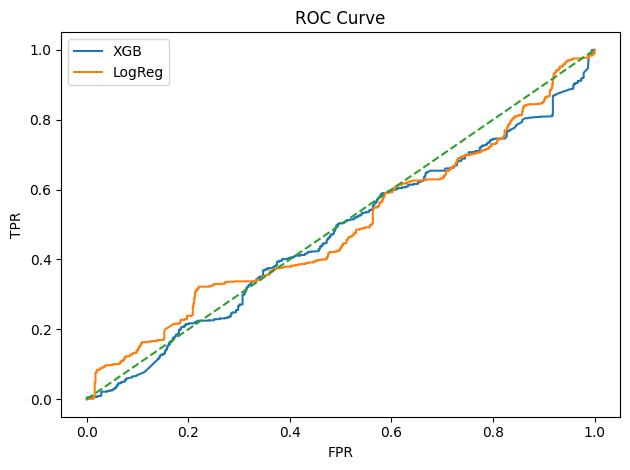

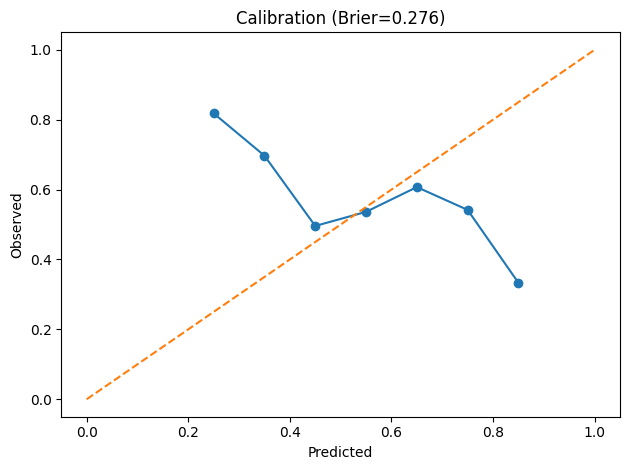

XGB overall: {'AUC': 0.4734262793052419, 'ACC': 0.5435453983940705, 'F1': 0.596395412342982}
LogReg overall: {'AUC': 0.4927284056390685, 'ACC': 0.5521927115503397, 'F1': 0.5645645645645646}


In [24]:
log_res, log_p, log_y, log_hat, log_overall = run_walkforward_logreg(
    final_df, horizon_days=best['hz'], margin_eps=best['eps'], macro_lag_bdays=5,
    train_years=5, valid_months=6, test_months=6, step_months=3, expand=True
)

plot_roc_calibration(best['all_y'], best['all_p'], "XGB",
                     y_true_b=log_y, p_b=log_p, label_b="LogReg")
print("XGB overall:", best['overall'])
print("LogReg overall:", log_overall)


LogReg L/F: {'CAGR': 0.036969118225380404, 'Vol': 0.09466916236810143, 'Sharpe': 0.3905085594993821, 'MaxDD': -0.21691280919570044, 'Turnover': 8.872143298332304}
XGB   L/F: {'CAGR': 0.05354641154450457, 'Vol': 0.09200506113893167, 'Sharpe': 0.5819941955546026, 'MaxDD': -0.13506335784742007, 'Turnover': 9.494749845583694}


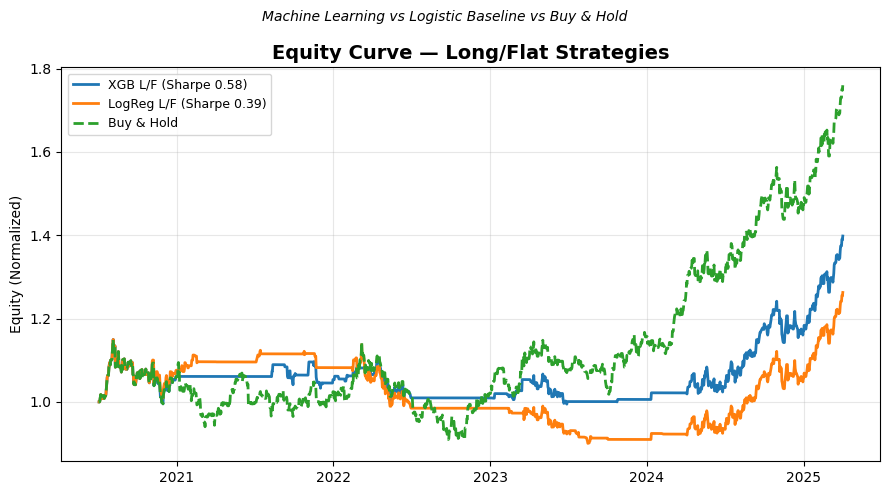

In [65]:
gold_px = final_df.drop_duplicates(subset='Date').set_index('Date')['Gold_GC=F'].asfreq('D').ffill()


log_p = pd.Series(log_p.values, index=pd.to_datetime(log_p.index).floor('D'))
xgb_p = pd.Series(best['all_p'].values, index=pd.to_datetime(best['all_p'].index).floor('D'))

# sabit eşik (XGB ile karşılaştırılabilir)
btL_log, eqL_log = backtest_from_probs(log_p, gold_px, thr_long=0.6, long_short=False, costs_bps=2)
btL_xgb, eqL_xgb = backtest_from_probs(xgb_p, gold_px, thr_long=0.6, long_short=False, costs_bps=2)

bh = (1 + gold_px.pct_change().fillna(0)).cumprod()
bh = bh.loc[eqL_xgb.index.min():eqL_xgb.index.max()]  # aynı tarih aralığına kes

print("LogReg L/F:", btL_log)
print("XGB   L/F:", btL_xgb)

plt.figure(figsize=(9,5))
plt.plot(eqL_xgb.index, eqL_xgb['eq'], label=f'XGB L/F (Sharpe {btL_xgb["Sharpe"]:.2f})', linewidth=2)
plt.plot(eqL_log.index, eqL_log['eq'], label=f'LogReg L/F (Sharpe {btL_log["Sharpe"]:.2f})', linewidth=2)
plt.plot(bh.index, bh/bh.iloc[0], label='Buy & Hold', linestyle='--', linewidth=2)

plt.title("Equity Curve — Long/Flat Strategies", fontsize=14, weight="bold")
plt.suptitle("Machine Learning vs Logistic Baseline vs Buy & Hold", fontsize=10, style="italic")
plt.ylabel("Equity (Normalized)")
plt.grid(alpha=0.3)
plt.legend(loc="upper left", frameon=True, fontsize=9)
plt.tight_layout()
plt.show()


In [26]:
def calibrate_probs(p_train, y_train, p_to_cal):
    y_unique = np.unique(y_train.astype(int))
    if len(y_unique) < 2:
        return p_to_cal.ravel()
    ir = IsotonicRegression(out_of_bounds='clip')
    ir.fit(p_train.ravel(), y_train.astype(int))
    return ir.transform(p_to_cal.ravel())

def select_threshold(y_valid, p_valid_cal, method='quantile', q=0.6):
    if method == 'f1':
        thr_grid = np.linspace(0.2, 0.8, 25)
        f1s = [f1_score(y_valid, (p_valid_cal>=t).astype(int)) for t in thr_grid]
        return float(thr_grid[int(np.argmax(f1s))])
    return float(np.quantile(p_valid_cal, q))

def walk_forward_masks_flex(dates,
                            train_years=5, valid_months=6, test_months=6,
                            step_months=3, expand=True):
    dates = pd.to_datetime(dates)
    start, end = dates.min(), dates.max()
    folds, anchor, cursor = [], start, start

    while True:
        train_start = anchor if expand else cursor
        train_end   = cursor + pd.DateOffset(years=train_years)
        valid_end   = train_end + pd.DateOffset(months=valid_months)
        test_end    = valid_end + pd.DateOffset(months=test_months)
        if test_end > end: break

        mtr = (dates > train_start) & (dates <= train_end)
        mva = (dates > train_end)   & (dates <= valid_end)
        mte = (dates > valid_end)   & (dates <= test_end)
        if mtr.sum() and mva.sum() and mte.sum():
            folds.append((mtr, mva, mte, train_end, valid_end, test_end))
        cursor = cursor + pd.DateOffset(months=step_months)
    return folds

2) XGBoost Walk-Forward (temiz)

In [27]:
def run_walkforward_xgb(final_df,
                        horizon_days=20, margin_eps=0.003, macro_lag_bdays=5,
                        train_years=5, valid_months=6, test_months=6, step_months=3, expand=True,
                        threshold_method='quantile'):
    # Model matrisi
    X_all, y_all, dates_all = build_model_matrix(
        final_df, horizon_days=horizon_days, margin_eps=margin_eps,
        drop_crypto=True, engineered_only=True, max_nan_frac=0.20, macro_lag_bdays=macro_lag_bdays
    )
    folds = walk_forward_masks_flex(dates_all, train_years, valid_months, test_months, step_months, expand)
    print(f"{len(folds)} fold (XGB)")

    results, all_p, all_y, all_hat = [], [], [], []
    for i, (mtr, mva, mte, tr_end, va_end, te_end) in enumerate(folds, 1):
        X_tr, y_tr = X_all[mtr], y_all[mtr]
        X_va, y_va = X_all[mva], y_all[mva]
        X_te, y_te = X_all[mte], y_all[mte]

        med = X_tr.median()
        X_tr = X_tr.fillna(med); X_va = X_va.fillna(med); X_te = X_te.fillna(med)

        dtrain = xgb.DMatrix(X_tr.astype(np.float32), label=y_tr.astype(np.int32))
        dvalid = xgb.DMatrix(X_va.astype(np.float32), label=y_va.astype(np.int32))
        dtest  = xgb.DMatrix(X_te.astype(np.float32))

        pos = int((y_tr==1).sum()); neg = int((y_tr==0).sum())
        params = {
            "max_depth":5, "eta":0.03, "min_child_weight":5,
            "subsample":0.8, "colsample_bytree":0.8,
            "objective":"binary:logistic", "eval_metric":"auc",
            "tree_method":"hist", "scale_pos_weight": max(1.0, neg/max(1,pos))
        }
        bst = xgb.train(params, dtrain, num_boost_round=3000,
                        evals=[(dtrain,"train"),(dvalid,"valid")],
                        early_stopping_rounds=100, verbose_eval=False)

        try:
            p_va = bst.predict(dvalid, iteration_range=(0, bst.best_iteration+1))
            p_te = bst.predict(dtest,  iteration_range=(0, bst.best_iteration+1))
        except TypeError:
            p_va = bst.predict(dvalid, ntree_limit=getattr(bst,"best_ntree_limit",bst.best_iteration+1))
            p_te = bst.predict(dtest,  ntree_limit=getattr(bst,"best_ntree_limit",bst.best_iteration+1))

        p_va_cal = calibrate_probs(p_va.reshape(-1,1), y_va.values, p_va.reshape(-1,1))
        p_te_cal = calibrate_probs(p_va.reshape(-1,1), y_va.values, p_te.reshape(-1,1))
        thr_star = select_threshold(y_va, p_va_cal, method=threshold_method)
        yhat_te  = (p_te_cal >= thr_star).astype(int)

        auc_v = float(getattr(bst, "best_score", roc_auc_score(y_va, p_va)))
        auc_t = roc_auc_score(y_te, p_te) if len(np.unique(y_te))>1 else np.nan
        acc_t = accuracy_score(y_te, yhat_te)
        f1_t  = f1_score(y_te, yhat_te)

        print(f"Fold {i:02d} | train≤{tr_end.date()} valid≤{va_end.date()} test≤{te_end.date()} "
              f"| AUCv={auc_v:.3f} AUCt={auc_t:.3f} thr={thr_star:.3f} "
              f"| ACC={acc_t:.3f} F1={f1_t:.3f}")


        idx_te  = pd.to_datetime(dates_all[mte])
        if hasattr(idx_te , "dt"):  # Series ise
            idx_te  = idx_te .dt.floor("D")
        else:  
            idx_te  = idx_te .floor("D")
        all_p.append(pd.Series(p_te_cal, index=idx_te))
        all_y.append(pd.Series(y_te.values, index=idx_te))
        all_hat.append(pd.Series(yhat_te, index=idx_te))
        results.append({"fold":i,"train_end":tr_end,"valid_end":va_end,"test_end":te_end,
                        "valid_auc":auc_v,"test_auc":auc_t,"acc":acc_t,"f1":f1_t})

    res_df  = pd.DataFrame(results).sort_values("fold")
    all_p   = pd.concat(all_p).sort_index()
    all_y   = pd.concat(all_y).sort_index().astype(int)
    all_hat = pd.concat(all_hat).sort_index().astype(int)

    all_p   = all_p[~all_p.index.duplicated(keep='last')]
    all_y   = all_y[~all_y.index.duplicated(keep='last')]
    all_hat = all_hat[~all_hat.index.duplicated(keep='last')]

    overall = {
        "AUC": roc_auc_score(all_y, all_p),
        "ACC": accuracy_score(all_y, all_hat),
        "F1":  f1_score(all_y, all_hat)
    }
    return res_df, all_p, all_y, all_hat, overall


3) Logistic baseline

In [28]:
def run_walkforward_logreg(final_df,
                           horizon_days=20, margin_eps=0.003, macro_lag_bdays=5,
                           train_years=5, valid_months=6, test_months=6, step_months=3, expand=True,
                           threshold_method='quantile'):
    X_all, y_all, dates_all = build_model_matrix(
        final_df, horizon_days=horizon_days, margin_eps=margin_eps,
        drop_crypto=True, engineered_only=True, max_nan_frac=0.20, macro_lag_bdays=macro_lag_bdays
    )
    folds = walk_forward_masks_flex(dates_all, train_years, valid_months, test_months, step_months, expand)
    print(f"{len(folds)} fold (LogReg)")

    results, all_p, all_y, all_hat = [], [], [], []
    for i, (mtr, mva, mte, tr_end, va_end, te_end) in enumerate(folds, 1):
        X_tr, y_tr = X_all[mtr], y_all[mtr]
        X_va, y_va = X_all[mva], y_all[mva]
        X_te, y_te = X_all[mte], y_all[mte]

        pipe = Pipeline([("scaler", StandardScaler()),
                         ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))])
        pipe.fit(X_tr, y_tr)
        p_va = pipe.predict_proba(X_va)[:,1]
        p_te = pipe.predict_proba(X_te)[:,1]

        p_va_cal = calibrate_probs(p_va.reshape(-1,1), y_va.values, p_va.reshape(-1,1))
        p_te_cal = calibrate_probs(p_va.reshape(-1,1), y_va.values, p_te.reshape(-1,1))
        thr_star = select_threshold(y_va, p_va_cal, method=threshold_method)
        yhat_te  = (p_te_cal >= thr_star).astype(int)

        auc_v = roc_auc_score(y_va, p_va) if len(np.unique(y_va))>1 else np.nan
        auc_t = roc_auc_score(y_te, p_te) if len(np.unique(y_te))>1 else np.nan
        acc_t = accuracy_score(y_te, yhat_te)
        f1_t  = f1_score(y_te, yhat_te)

        print(f"Fold {i:02d} | train≤{tr_end.date()} valid≤{va_end.date()} test≤{te_end.date()} "
              f"| AUCv={auc_v:.3f} AUCt={auc_t:.3f} thr={thr_star:.3f} | ACC={acc_t:.3f} F1={f1_t:.3f}")

        idx_te = pd.to_datetime(dates_all[mte].copy())
        if hasattr(idx_te, "dt"):      
            idx_te = idx_te.dt.floor("D")
        else:                          
            idx_te = idx_te.floor("D")


        all_p.append(pd.Series(p_te_cal, index=idx_te))
        all_y.append(pd.Series(y_te.values, index=idx_te))
        all_hat.append(pd.Series(yhat_te, index=idx_te))
        results.append({"fold":i,"train_end":tr_end,"valid_end":va_end,"test_end":te_end,
                        "valid_auc":auc_v,"test_auc":auc_t,"acc":acc_t,"f1":f1_t})

    res_df  = pd.DataFrame(results).sort_values("fold")
    all_p   = pd.concat(all_p).sort_index()
    all_y   = pd.concat(all_y).sort_index().astype(int)
    all_hat = pd.concat(all_hat).sort_index().astype(int)
    all_p   = all_p[~all_p.index.duplicated(keep='last')]
    all_y   = all_y[~all_y.index.duplicated(keep='last')]
    all_hat = all_hat[~all_hat.index.duplicated(keep='last')]

    overall = {"AUC": roc_auc_score(all_y, all_p),
               "ACC": accuracy_score(all_y, all_hat),
               "F1":  f1_score(all_y, all_hat)}
    return res_df, all_p, all_y, all_hat, overall


4) Makro-lag Sensitivity

In [29]:
def macro_lag_sweep(final_df, hz, eps, lags=(0,5,10,15), model='logreg'):
    rows=[]
    for lag in lags:
        if model=='logreg':
            _, _, _, _, ov = run_walkforward_logreg(final_df, horizon_days=hz, margin_eps=eps,
                                                    macro_lag_bdays=lag, train_years=5, valid_months=6,
                                                    test_months=6, step_months=3, expand=True)
        else:
            _, _, _, _, ov = run_walkforward_xgb(final_df, horizon_days=hz, margin_eps=eps,
                                                 macro_lag_bdays=lag, train_years=5, valid_months=6,
                                                 test_months=6, step_months=3, expand=True)
        rows.append({"macro_lag":lag, **ov})
    df = pd.DataFrame(rows).sort_values("AUC", ascending=False)
    print(df)

    plt.figure(figsize=(6,4))
    plt.plot(df.sort_values('macro_lag')['macro_lag'], df.sort_values('macro_lag')['AUC'], marker='o', label='AUC')
    plt.plot(df.sort_values('macro_lag')['macro_lag'], df.sort_values('macro_lag')['ACC'], marker='o', label='ACC')
    plt.plot(df.sort_values('macro_lag')['macro_lag'], df.sort_values('macro_lag')['F1'],  marker='o', label='F1')
    plt.xlabel("Macro lag (business days)"); plt.title("Macro Lag Sweep"); plt.legend(); plt.tight_layout(); plt.show()
    return df


5) Feature Pruning (MI) + WFO

In [40]:
def get_topk_by_mi(final_df, horizon_days, margin_eps, macro_lag_bdays, k=40):
    X_all, y_all, _ = build_model_matrix(
        final_df, horizon_days=horizon_days, margin_eps=margin_eps,
        drop_crypto=True, engineered_only=True, max_nan_frac=0.20, macro_lag_bdays=macro_lag_bdays
    )
    X_all = X_all.fillna(X_all.median())
    mi = mutual_info_classif(X_all, y_all, random_state=0, discrete_features='auto')
    mi_s = pd.Series(mi, index=X_all.columns).sort_values(ascending=False)
    return mi_s.index[:k].tolist(), mi_s

def run_with_selected_columns(final_df, use_cols, model="logreg",
                              horizon_days=20, margin_eps=0.003, macro_lag_bdays=5):
    X_all, y_all, dates_all = build_model_matrix(
        final_df, horizon_days=horizon_days, margin_eps=margin_eps,
        drop_crypto=True, engineered_only=True, max_nan_frac=0.20, macro_lag_bdays=macro_lag_bdays
    )
    X_all = X_all[use_cols].copy()
    folds = walk_forward_masks_flex(dates_all, 5, 6, 6, 3, True)

    results, all_p, all_y, all_hat = [], [], [], []
    for i,(mtr,mva,mte,tr_end,va_end,te_end) in enumerate(folds,1):
        X_tr, y_tr = X_all[mtr], y_all[mtr]
        X_va, y_va = X_all[mva], y_all[mva]
        X_te, y_te = X_all[mte], y_all[mte]

        if model=="logreg":
            pipe = Pipeline([("scaler", StandardScaler()),
                             ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))])
            pipe.fit(X_tr, y_tr)
            p_va = pipe.predict_proba(X_va)[:,1]
            p_te = pipe.predict_proba(X_te)[:,1]
        else:
            dtrain = xgb.DMatrix(X_tr.astype(np.float32), label=y_tr.astype(np.int32))
            dvalid = xgb.DMatrix(X_va.astype(np.float32), label=y_va.astype(np.int32))
            dtest  = xgb.DMatrix(X_te.astype(np.float32))
            pos = int((y_tr==1).sum()); neg = int((y_tr==0).sum())
            params = {"max_depth":5,"eta":0.03,"min_child_weight":5,"subsample":0.8,
                      "colsample_bytree":0.8,"objective":"binary:logistic","eval_metric":"auc",
                      "tree_method":"hist","scale_pos_weight": max(1.0, neg/max(1,pos))}
            bst = xgb.train(params, dtrain, 3000, evals=[(dtrain,"train"),(dvalid,"valid")],
                            early_stopping_rounds=100, verbose_eval=False)
            try:
                p_va = bst.predict(dvalid, iteration_range=(0, bst.best_iteration+1))
                p_te = bst.predict(dtest,  iteration_range=(0, bst.best_iteration+1))
            except TypeError:
                p_va = bst.predict(dvalid, ntree_limit=getattr(bst,"best_ntree_limit",bst.best_iteration+1))
                p_te = bst.predict(dtest,  ntree_limit=getattr(bst,"best_ntree_limit",bst.best_iteration+1))

        p_va_cal = calibrate_probs(p_va.reshape(-1,1), y_va.values, p_va.reshape(-1,1))
        p_te_cal = calibrate_probs(p_va.reshape(-1,1), y_va.values, p_te.reshape(-1,1))
        thr = select_threshold(y_va, p_va_cal, method='quantile')
        yhat = (p_te_cal >= thr).astype(int)

        auc_v = roc_auc_score(y_va, p_va) if len(np.unique(y_va))>1 else np.nan
        auc_t = roc_auc_score(y_te, p_te) if len(np.unique(y_te))>1 else np.nan
        acc_t = accuracy_score(y_te, yhat)
        f1_t  = f1_score(y_te, yhat)

        results.append({"fold":i,"valid_auc":auc_v,"test_auc":auc_t,"acc":acc_t,"f1":f1_t})
        #idx_te = pd.to_datetime(dates_all[mte]).normalize()
        idx_te = pd.to_datetime(dates_all[mte]).dt.date
        all_p.append(pd.Series(p_te_cal, index=idx_te))
        all_y.append(pd.Series(y_te.values, index=idx_te))
        all_hat.append(pd.Series(yhat, index=idx_te))

    res_df  = pd.DataFrame(results)
    all_p   = pd.concat(all_p).sort_index()
    all_y   = pd.concat(all_y).sort_index().astype(int)
    all_hat = pd.concat(all_hat).sort_index().astype(int)
    all_p   = all_p[~all_p.index.duplicated(keep='last')]
    all_y   = all_y[~all_y.index.duplicated(keep='last')]
    all_hat = all_hat[~all_hat.index.duplicated(keep='last')]

    overall = {"AUC": roc_auc_score(all_y, all_p),
               "ACC": accuracy_score(all_y, all_hat),
               "F1":  f1_score(all_y, all_hat)}
    return res_df, all_p, all_y, all_hat, overall


6) Backtest stationary treshold 

In [31]:
def backtest_from_probs(prob_s, price_s, thr_long=0.6, thr_short=0.4, costs_bps=2, long_short=False):
    prob_s = prob_s[~prob_s.index.duplicated(keep='last')]
    price_s = price_s[~price_s.index.duplicated(keep='last')].asfreq('D').ffill()

    df = pd.concat([prob_s.rename('p'), price_s.rename('px')], axis=1).dropna()
    if df.empty or len(df)<2:
        raise ValueError("Backtest için kesişim yok/az.")

    df['pos'] = 0.0
    if long_short:
        df.loc[df['p']>=thr_long, 'pos'] = 1.0
        df.loc[df['p']<=thr_short, 'pos'] = -1.0
    else:
        df.loc[df['p']>=thr_long, 'pos'] = 1.0

    df['ret'] = df['px'].pct_change().fillna(0)
    df['turnover'] = df['pos'].diff().abs().fillna(abs(df['pos']))
    cost = costs_bps*1e-4
    df['strat_ret'] = df['pos'].shift(1)*df['ret'] - cost*df['turnover']
    df['eq'] = (1+df['strat_ret']).cumprod()

    cagr = (df['eq'].iloc[-1])**(252/max(1,len(df))) - 1
    vol  = df['strat_ret'].std()*np.sqrt(252)
    sharpe = cagr/vol if vol>0 else 0
    mdd = (df['eq']/df['eq'].cummax()-1).min()
    return {'CAGR':cagr, 'Vol':vol, 'Sharpe':sharpe, 'MaxDD':mdd, 'Turnover':df['turnover'].mean()*252}, df


7) HMM Regimes + regime positioning

In [ ]:
def fit_hmm_regimes(final_df, n_states=3):
    f = final_df.copy()
    f['Date'] = pd.to_datetime(f['Date'])
    f = f.sort_values('Date').set_index('Date')
    cols = [c for c in ['Gold_volatility_20d','VIX_^VIX','Dollar_DX-Y.NYB','Gold_RSI','Gold_MACD'] if c in f.columns]
    if len(cols)<3: raise ValueError("HMM için en az 3 sağlam feature gerekli.")
    X = f[cols].dropna().values
    idx = f[cols].dropna().index

    hmm = GaussianHMM(n_components=n_states, covariance_type='diag', n_iter=200, random_state=42)
    hmm.fit(X)
    states = hmm.predict(X)

    gold_ret = f['Gold_GC=F'].pct_change().reindex(idx)
    means = [(s, float(gold_ret[states==s].mean())) for s in range(n_states)]
    order = [s for s,_ in sorted(means, key=lambda x:x[1])]
    mapping = {order[0]:"Risk-Off", order[-1]:"Risk-On"}
    if n_states==3: mapping[order[1]]="Neutral"

    reg = pd.Series(states, index=idx).map(mapping).reindex(f.index).ffill()
    return reg, hmm

def plot_transition_matrix(hmm):
    T = hmm.transmat_
    plt.figure(figsize=(4,3))
    plt.imshow(T, cmap='Blues'); plt.colorbar()
    for i in range(T.shape[0]):
        for j in range(T.shape[1]):
            plt.text(j,i,f"{T[i,j]:.2f}",ha='center',va='center')
    plt.title("HMM Transition Matrix"); plt.xlabel("to"); plt.ylabel("from")
    plt.tight_layout(); plt.show()

def backtest_with_pos_series(pos_s, price_s, costs_bps=2):
    pos_s = pos_s[~pos_s.index.duplicated(keep='last')]
    price_s = price_s[~price_s.index.duplicated(keep='last')].asfreq('D').ffill()
    df = pd.concat([pos_s.rename('pos'), price_s.rename('px')], axis=1).dropna()
    df['ret'] = df['px'].pct_change().fillna(0)
    cost = costs_bps*1e-4
    df['turnover'] = df['pos'].diff().abs().fillna(abs(df['pos']))
    df['strat_ret'] = df['pos'].shift(1)*df['ret'] - cost*df['turnover']
    df['eq'] = (1+df['strat_ret']).cumprod()
    cagr = (df['eq'].iloc[-1])**(252/max(1,len(df))) - 1
    vol  = df['strat_ret'].std()*np.sqrt(252)
    sharpe = cagr/vol if vol>0 else 0
    mdd = (df['eq']/df['eq'].cummax()-1).min()
    return {'CAGR':cagr,'Vol':vol,'Sharpe':sharpe,'MaxDD':mdd,'Turnover':df['turnover'].mean()*252}, df


In [33]:
HZ  = 20
EPS = 0.003
LAG = 5

#  XGBoost walk-forward
res_xgb, p_xgb, y_xgb, hat_xgb, ov_xgb = run_walkforward_xgb(
    final_df, horizon_days=HZ, margin_eps=EPS, macro_lag_bdays=LAG,
    train_years=5, valid_months=6, test_months=6, step_months=3, expand=True,
    threshold_method='quantile'
)
print("\n=== XGB OVERALL ===")
print(ov_xgb)
print("\nXGB fold summary (first 8 rows):")
print(res_xgb[['fold','train_end','valid_end','test_end','valid_auc','test_auc','acc','f1']].head(8))

18 fold (XGB)
Fold 01 | train≤2020-01-02 valid≤2020-07-02 test≤2021-01-02 | AUCv=0.582 AUCt=0.402 thr=0.827 | ACC=0.468 F1=0.098
Fold 02 | train≤2020-04-02 valid≤2020-10-02 test≤2021-04-02 | AUCv=0.616 AUCt=0.608 thr=0.684 | ACC=0.491 F1=0.558
Fold 03 | train≤2020-07-02 valid≤2021-01-02 test≤2021-07-02 | AUCv=0.587 AUCt=0.488 thr=0.368 | ACC=0.529 F1=0.685
Fold 04 | train≤2020-10-02 valid≤2021-04-02 test≤2021-10-02 | AUCv=0.582 AUCt=0.725 thr=0.421 | ACC=0.546 F1=0.378
Fold 05 | train≤2021-01-02 valid≤2021-07-02 test≤2022-01-02 | AUCv=0.655 AUCt=0.562 thr=0.684 | ACC=0.529 F1=0.545
Fold 06 | train≤2021-04-02 valid≤2021-10-02 test≤2022-04-02 | AUCv=0.872 AUCt=0.544 thr=0.800 | ACC=0.392 F1=0.357
Fold 07 | train≤2021-07-02 valid≤2022-01-02 test≤2022-07-02 | AUCv=0.777 AUCt=0.649 thr=0.667 | ACC=0.588 F1=0.615
Fold 08 | train≤2021-10-02 valid≤2022-04-02 test≤2022-10-02 | AUCv=0.751 AUCt=0.743 thr=0.772 | ACC=0.371 F1=0.451
Fold 09 | train≤2022-01-02 valid≤2022-07-02 test≤2023-01-02 | AUCv

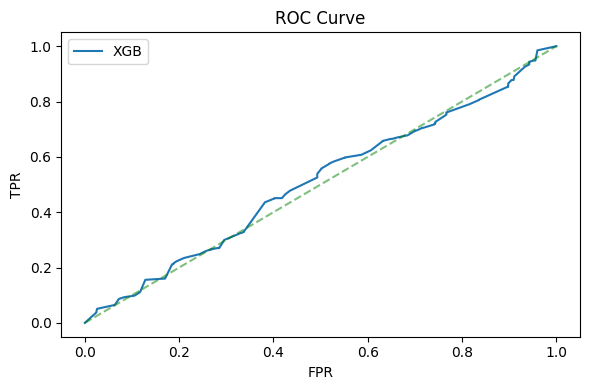

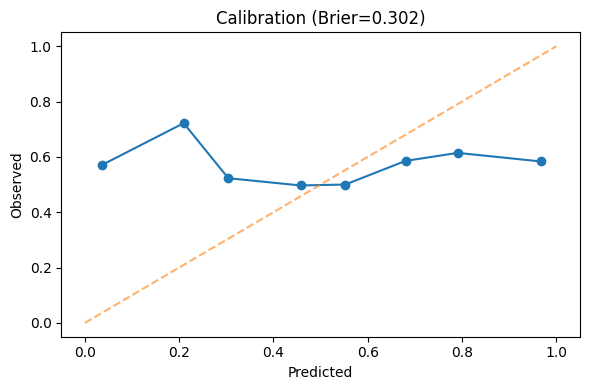

In [34]:
# ROC + Calibration (XGB)
from sklearn.calibration import calibration_curve
def plot_roc_calibration2(y_true_a, p_a, label_a, y_true_b=None, p_b=None, label_b=None):
    from sklearn.metrics import roc_curve, brier_score_loss
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,4))
    fpr,tpr,_=roc_curve(y_true_a, p_a); plt.plot(fpr,tpr,label=label_a)
    if y_true_b is not None:
        fpr2,tpr2,_=roc_curve(y_true_b,p_b); plt.plot(fpr2,tpr2,label=label_b)
    plt.plot([0,1],[0,1],'g--',alpha=.5); plt.title("ROC Curve"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,4))
    prob_true, prob_pred = calibration_curve(y_true_a, p_a, n_bins=8, strategy='uniform')
    brier = brier_score_loss(y_true_a, p_a)
    plt.plot(prob_pred, prob_true, marker='o'); plt.plot([0,1],[0,1],'--',alpha=.6)
    plt.title(f"Calibration (Brier={brier:.3f})"); plt.xlabel("Predicted"); plt.ylabel("Observed")
    plt.tight_layout(); plt.show()

plot_roc_calibration2(y_xgb, p_xgb, "XGB")

In [35]:
# 2) Basic backtests (LF/LS ve quantile-treshold)
gold_px = (final_df.drop_duplicates('Date')
                    .set_index('Date')['Gold_GC=F']
                    .asfreq('D').ffill())

mLF, eqLF = backtest_from_probs(p_xgb, gold_px, thr_long=0.60, long_short=False, costs_bps=2)
mLS, eqLS = backtest_from_probs(p_xgb, gold_px, thr_long=0.60, thr_short=0.40, long_short=True, costs_bps=2)
q_hi, q_lo = float(p_xgb.quantile(0.70)), float(p_xgb.quantile(0.30))
mLFq,_ = backtest_from_probs(p_xgb, gold_px, thr_long=q_hi, long_short=False, costs_bps=2)
mLSq,_ = backtest_from_probs(p_xgb, gold_px, thr_long=q_hi, thr_short=q_lo, long_short=True, costs_bps=2)

print("\nBacktest (Long/Flat):", mLF)
print("Backtest (Long/Short):", mLS)
print("Backtest-Quantile (LF):", mLFq)
print("Backtest-Quantile (LS):", mLSq)


Backtest (Long/Flat): {'CAGR': 0.01573469641172709, 'Vol': 0.09668329703647852, 'Sharpe': 0.16274472317374947, 'MaxDD': -0.32107594560646113, 'Turnover': 55.56763434218654}
Backtest (Long/Short): {'CAGR': -0.037941535177600016, 'Vol': 0.12088837355164292, 'Sharpe': -0.3138559487806458, 'MaxDD': -0.5073673914236999, 'Turnover': 118.7621988882026}
Backtest-Quantile (LF): {'CAGR': -0.016212134196878947, 'Vol': 0.07796479924610683, 'Sharpe': -0.20794171669323575, 'MaxDD': -0.28660187180986485, 'Turnover': 60.39283508338481}
Backtest-Quantile (LS): {'CAGR': -0.06819725747563243, 'Vol': 0.10641950321361227, 'Sharpe': -0.640834202530925, 'MaxDD': -0.4926671964978734, 'Turnover': 123.58739962940086}


18 fold (LogReg)
Fold 01 | train≤2020-01-02 valid≤2020-07-02 test≤2021-01-02 | AUCv=0.458 AUCt=0.682 thr=0.743 | ACC=0.462 F1=0.632
Fold 02 | train≤2020-04-02 valid≤2020-10-02 test≤2021-04-02 | AUCv=0.652 AUCt=0.475 thr=0.714 | ACC=0.291 F1=0.387
Fold 03 | train≤2020-07-02 valid≤2021-01-02 test≤2021-07-02 | AUCv=0.786 AUCt=0.467 thr=0.500 | ACC=0.488 F1=0.620
Fold 04 | train≤2020-10-02 valid≤2021-04-02 test≤2021-10-02 | AUCv=0.405 AUCt=0.470 thr=0.400 | ACC=0.580 F1=0.731
Fold 05 | train≤2021-01-02 valid≤2021-07-02 test≤2022-01-02 | AUCv=0.434 AUCt=0.614 thr=0.551 | ACC=0.576 F1=0.731
Fold 06 | train≤2021-04-02 valid≤2021-10-02 test≤2022-04-02 | AUCv=0.478 AUCt=0.592 thr=0.550 | ACC=0.729 F1=0.838
Fold 07 | train≤2021-07-02 valid≤2022-01-02 test≤2022-07-02 | AUCv=0.637 AUCt=0.712 thr=0.772 | ACC=0.624 F1=0.360
Fold 08 | train≤2021-10-02 valid≤2022-04-02 test≤2022-10-02 | AUCv=0.570 AUCt=0.556 thr=0.807 | ACC=0.747 F1=0.118
Fold 09 | train≤2022-01-02 valid≤2022-07-02 test≤2023-01-02 | A

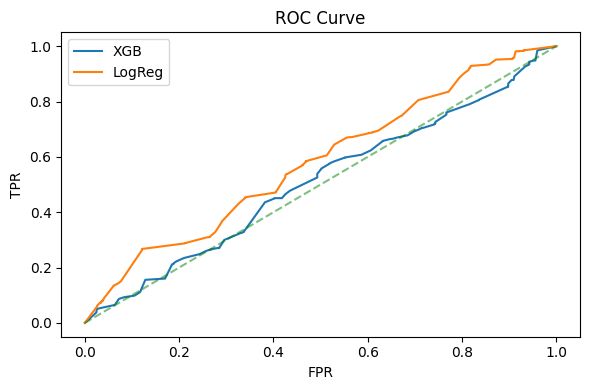

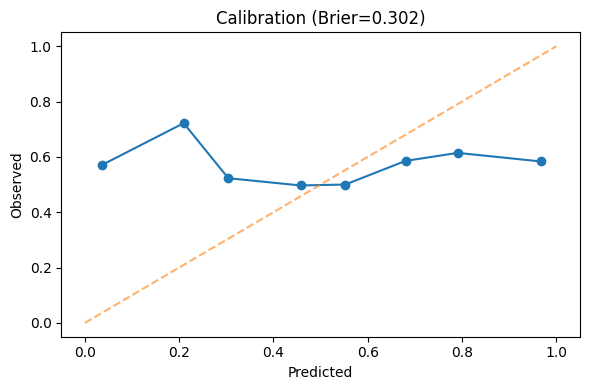

In [ ]:
# 3) Logistic baseline and ROC Comparison
res_lr, p_lr, y_lr, hat_lr, ov_lr = run_walkforward_logreg(
    final_df, horizon_days=HZ, margin_eps=EPS, macro_lag_bdays=LAG,
    train_years=5, valid_months=6, test_months=6, step_months=3, expand=True,
    threshold_method='quantile'
)
print("\n=== LogReg OVERALL ===")
print(ov_lr)
plot_roc_calibration2(y_xgb, p_xgb, "XGB", y_true_b=y_lr, p_b=p_lr, label_b="LogReg")

18 fold (LogReg)
Fold 01 | train≤2020-01-02 valid≤2020-07-02 test≤2021-01-02 | AUCv=0.458 AUCt=0.682 thr=0.743 | ACC=0.462 F1=0.632
Fold 02 | train≤2020-04-02 valid≤2020-10-02 test≤2021-04-02 | AUCv=0.652 AUCt=0.475 thr=0.714 | ACC=0.291 F1=0.387
Fold 03 | train≤2020-07-02 valid≤2021-01-02 test≤2021-07-02 | AUCv=0.786 AUCt=0.467 thr=0.500 | ACC=0.488 F1=0.620
Fold 04 | train≤2020-10-02 valid≤2021-04-02 test≤2021-10-02 | AUCv=0.405 AUCt=0.470 thr=0.400 | ACC=0.580 F1=0.731
Fold 05 | train≤2021-01-02 valid≤2021-07-02 test≤2022-01-02 | AUCv=0.434 AUCt=0.614 thr=0.551 | ACC=0.576 F1=0.731
Fold 06 | train≤2021-04-02 valid≤2021-10-02 test≤2022-04-02 | AUCv=0.478 AUCt=0.592 thr=0.550 | ACC=0.729 F1=0.838
Fold 07 | train≤2021-07-02 valid≤2022-01-02 test≤2022-07-02 | AUCv=0.637 AUCt=0.712 thr=0.772 | ACC=0.624 F1=0.360
Fold 08 | train≤2021-10-02 valid≤2022-04-02 test≤2022-10-02 | AUCv=0.570 AUCt=0.556 thr=0.807 | ACC=0.747 F1=0.118
Fold 09 | train≤2022-01-02 valid≤2022-07-02 test≤2023-01-02 | A

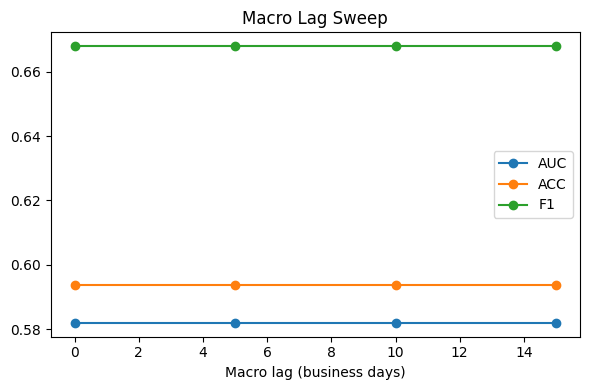


Top-30 MI (ilk 10):
 Gold_to_TIP_TIP            0.238152
Gold_to_IRX_^IRX           0.237115
Gold_Silver_spread         0.218147
Gold_GC=F_lag_1            0.214989
Gold_to_LQD_LQD            0.214987
Gold_to_NaturalGas_NG=F    0.214561
Gold_to_Crude_CL=F         0.205428
Gold_to_China_ETF_FXI      0.205388
Gold_to_Dollar_DX-Y.NYB    0.204448
Gold_GC=F_lag_2            0.202488
dtype: float64

Top-30 LogReg overall: {'AUC': 0.49348080068541167, 'ACC': 0.4762198888202594, 'F1': 0.5578727841501564}


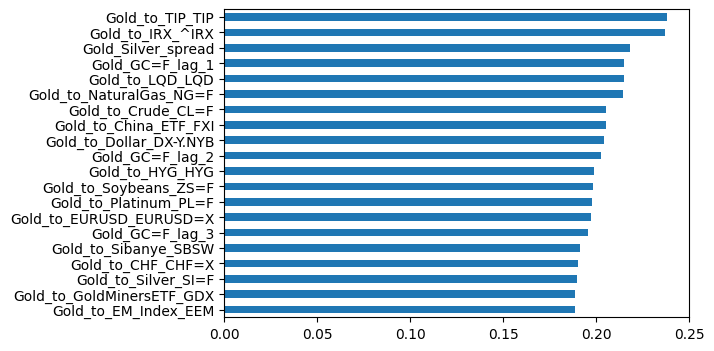

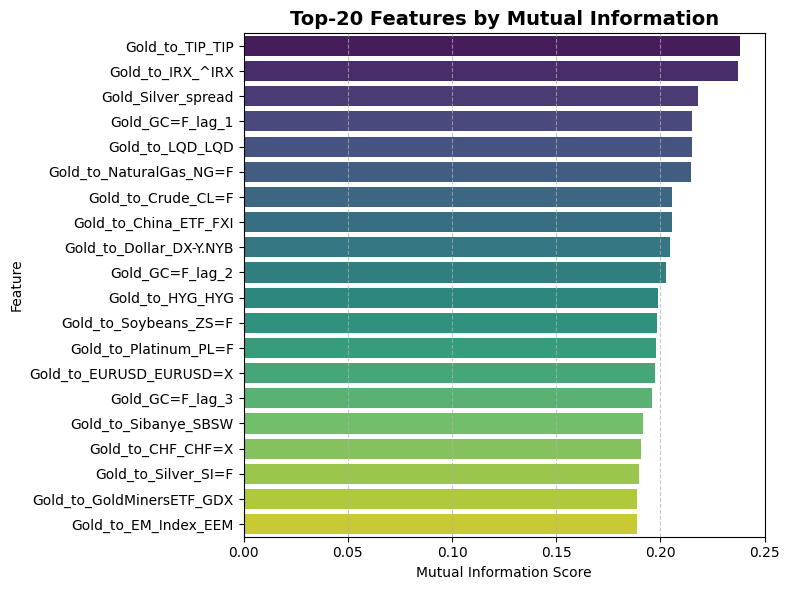

In [ ]:
lag_df = macro_lag_sweep(final_df, HZ, EPS, lags=(0,5,10,15), model='logreg')

top_cols, mi_series = get_topk_by_mi(final_df, HZ, EPS, macro_lag_bdays=LAG, k=30)
print("\nTop-30 MI (ilk 10):\n", mi_series.head(10))
res_top, p_top, y_top, hat_top, ov_top = run_with_selected_columns(
    final_df, use_cols=top_cols, model="logreg",
    horizon_days=HZ, margin_eps=EPS, macro_lag_bdays=LAG
)
print("\nTop-30 LogReg overall:", ov_top)
plt.figure(figsize=(6,4))
mi_series.head(20)[::-1].plot(kind='barh')
plt.figure(figsize=(8,6))
sns.barplot(
    y=mi_series.head(20).index, 
    x=mi_series.head(20).values,
    palette="viridis"
)
plt.title("Top-20 Features by Mutual Information", fontsize=14, weight="bold")
plt.xlabel("Mutual Information Score")
plt.ylabel("Feature")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Model is not converging.  Current: -31554.930882870274 is not greater than -31554.55542947037. Delta is -0.37545339990538196


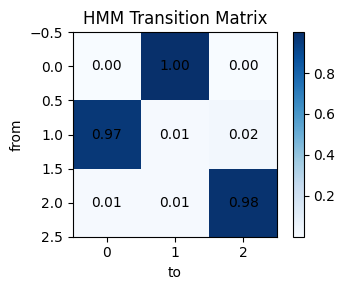


Backtest (Risk-On filtresi): {'CAGR': 0.012696243634429338, 'Vol': 0.08524373383189035, 'Sharpe': 0.14894049173711316, 'MaxDD': -0.24643886987888408, 'Turnover': 17.277331686226066}


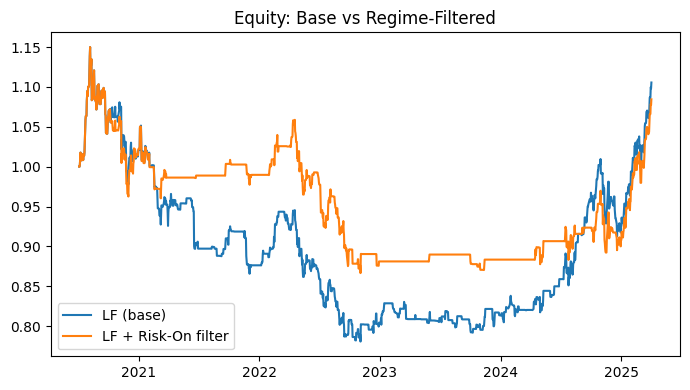

In [42]:
# 6) HMM rejimleri + rejim-akıllı pozisyon ve equity karşılaştırması
regime, hmm = fit_hmm_regimes(final_df, n_states=3)
plot_transition_matrix(hmm)

prob_sm = p_xgb.copy()
prob_sm.index = pd.to_datetime(prob_sm.index).normalize()
prob_sm = prob_sm[~prob_sm.index.duplicated(keep='last')].ewm(span=5, adjust=False).mean()

thr = 0.60
pos_raw = (prob_sm >= thr).astype(float)
reg_bin = (regime.reindex(pos_raw.index).fillna("Neutral")=="Risk-On").astype(float)
pos_reg = pos_raw * reg_bin

mReg, curveReg = backtest_with_pos_series(pos_reg, gold_px, costs_bps=2)
print("\nBacktest (Risk-On filtresi):", mReg)

plt.figure(figsize=(7,4))
plt.plot(eqLF.index, eqLF['eq'], label="LF (base)")
plt.plot(curveReg.index, curveReg['eq'], label="LF + Risk-On filter")
plt.title("Equity: Base vs Regime-Filtered"); plt.legend(); plt.tight_layout(); plt.show()

Model is not converging.  Current: -31554.930882870274 is not greater than -31554.55542947037. Delta is -0.37545339990538196


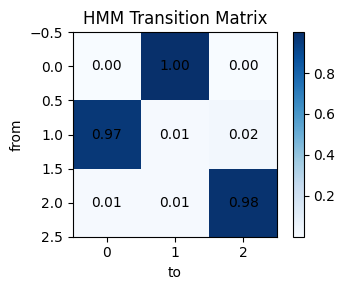

Backtest (Risk-On filtresi): {'CAGR': 0.03205730538473195, 'Vol': 0.08268123637422833, 'Sharpe': 0.38772164992351493, 'MaxDD': -0.15013522145501101, 'Turnover': 4.8252007411982705}


In [43]:
regime, hmm = fit_hmm_regimes(final_df, n_states=3)
plot_transition_matrix(hmm)

prob = best['all_p'].copy()
prob.index = pd.to_datetime(prob.index).normalize()
prob = prob[~prob.index.duplicated(keep='last')].ewm(span=5, adjust=False).mean()

thr = 0.60
pos_raw = (prob >= thr).astype(float)
reg_bin = (regime.reindex(pos_raw.index).fillna("Neutral")=="Risk-On").astype(float)
pos_reg = pos_raw * reg_bin

gold_px = final_df.drop_duplicates('Date').set_index('Date')['Gold_GC=F'].asfreq('D').ffill()
met_reg, curve_reg = backtest_with_pos_series(pos_reg, gold_px, costs_bps=2)
print("Backtest (Risk-On filtresi):", met_reg)


# LSTM

LSTM için sekans hazırlama + walk-forward eğitim/değerlendirme

In [46]:
# ==== LSTM helpers ==========================================


def _make_sequences(X_df, y_s, dates, seq_len=60):
    """
    X_df: DataFrame (zaman index sıralı)
    y_s : Series (X ile aynı index/sırada)
    dates: Series/Index -> zaman damgası
    seq_len: pencere uzunluğu
    Çıktı: X_seq (N, seq_len, F), y_seq (N,), dates_seq (N,)  -> her örnek pencerenin SON günü
    """
    X_np = X_df.values
    y_np = y_s.values.astype(int)
    n, f = X_np.shape
    if n < seq_len:
        return np.empty((0, seq_len, f)), np.array([]), pd.to_datetime(pd.Index([]))

    X_list, y_list, d_list = [], [], []
    # her t noktası için [t-seq_len+1 ... t] penceresi
    for t in range(seq_len-1, n):
        X_list.append(X_np[t-seq_len+1:t+1])
        y_list.append(y_np[t])
        d_list.append(dates.iloc[t] if hasattr(dates, "iloc") else dates[t])

    X_seq = np.stack(X_list)
    y_seq = np.array(y_list)
    d_seq = pd.to_datetime(pd.Index(d_list))
    return X_seq, y_seq, d_seq

# ==== LSTM walk-forward (direction forecast) =================================



def run_walkforward_lstm(final_df,
                         horizon_days=20,
                         margin_eps=0.003,
                         macro_lag_bdays=5,
                         seq_len=60,              
                         lstm_units=64,          
                         dropout=0.2,
                         lr=1e-3,
                         batch_size=64,
                         max_epochs=100,
                         es_patience=10,
                         train_years=5, valid_months=6, test_months=6,
                         step_months=3, expand=True,
                         threshold_method='quantile'):
    X_all, y_all, dates_all = build_model_matrix(
        final_df,
        horizon_days=horizon_days,
        margin_eps=margin_eps,
        drop_crypto=True,
        engineered_only=True,
        max_nan_frac=0.20,
        macro_lag_bdays=macro_lag_bdays
    )
    dates_all = pd.to_datetime(dates_all)

    folds = walk_forward_masks_flex(dates_all,
                                    train_years=train_years,
                                    valid_months=valid_months,
                                    test_months=test_months,
                                    step_months=step_months,
                                    expand=expand)
    print(f"{len(folds)} fold (LSTM hz={horizon_days}, eps={margin_eps}, seq={seq_len})")

    results = []
    all_p_list, all_y_list, all_hat_list = [], [], []

    for i, (mtr, mva, mte, tr_end, va_end, te_end) in enumerate(folds, 1):
        X_tr = X_all[mtr].copy()
        y_tr = y_all[mtr].copy()
        med_tr = X_tr.median()

        X_tr = X_tr.fillna(med_tr)
        X_va = X_all[mva].fillna(med_tr)
        X_te = X_all[mte].fillna(med_tr)

        scaler = StandardScaler()
        X_tr_s = pd.DataFrame(scaler.fit_transform(X_tr), index=X_tr.index, columns=X_tr.columns)
        X_va_s = pd.DataFrame(scaler.transform(X_va), index=X_va.index, columns=X_va.columns)
        X_te_s = pd.DataFrame(scaler.transform(X_te), index=X_te.index, columns=X_te.columns)

        X_tr_seq, y_tr_seq, d_tr_seq = _make_sequences(X_tr_s, y_tr, dates_all[mtr], seq_len=seq_len)
        X_va_seq, y_va_seq, d_va_seq = _make_sequences(X_va_s, y_all[mva], dates_all[mva], seq_len=seq_len)
        X_te_seq, y_te_seq, d_te_seq = _make_sequences(X_te_s, y_all[mte], dates_all[mte], seq_len=seq_len)

        # Boş split varsa atla
        if len(y_tr_seq)==0 or len(y_va_seq)==0 or len(y_te_seq)==0:
            print(f"Fold {i:02d} | Yetersiz veri (train/valid/test seq lens: "
                  f"{len(y_tr_seq)}/{len(y_va_seq)}/{len(y_te_seq)}) — atlandı.")
            continue

        inp = keras.Input(shape=(seq_len, X_tr_seq.shape[-1]))
        x = layers.LSTM(lstm_units)(inp)
        x = layers.Dropout(dropout)(x)
        x = layers.Dense(32, activation='relu')(x)
        out = layers.Dense(1, activation='sigmoid')(x)
        model = keras.Model(inp, out)
        model.compile(optimizer=keras.optimizers.Adam(lr),
                      loss='binary_crossentropy',
                      metrics=[keras.metrics.AUC(name='auc')])

        es = keras.callbacks.EarlyStopping(monitor='val_auc', mode='max',
                                           patience=es_patience, restore_best_weights=True)
        model.fit(X_tr_seq, y_tr_seq,
                  validation_data=(X_va_seq, y_va_seq),
                  epochs=max_epochs, batch_size=batch_size,
                  verbose=0, callbacks=[es])

        p_va = model.predict(X_va_seq, verbose=0).ravel()
        p_te = model.predict(X_te_seq, verbose=0).ravel()

        p_va_cal = calibrate_probs(p_va.reshape(-1,1), pd.Series(y_va_seq), p_va.reshape(-1,1))
        p_te_cal = calibrate_probs(p_va.reshape(-1,1), pd.Series(y_va_seq), p_te.reshape(-1,1))
        thr_star = select_threshold(pd.Series(y_va_seq), pd.Series(p_va_cal), method=threshold_method)
        yhat_te  = (p_te_cal >= thr_star).astype(int)

        auc_v = roc_auc_score(y_va_seq, p_va) if len(np.unique(y_va_seq))>1 else np.nan
        auc_t = roc_auc_score(y_te_seq, p_te) if len(np.unique(y_te_seq))>1 else np.nan
        acc_t = accuracy_score(y_te_seq, yhat_te)
        f1_t  = f1_score(y_te_seq, yhat_te)

        print(f"Fold {i:02d} | train≤{tr_end.date()} valid≤{va_end.date()} test≤{te_end.date()} "
              f"| AUCv={auc_v:.3f} AUCt={auc_t:.3f} thr={thr_star:.3f} "
              f"| ACC={acc_t:.3f} F1={f1_t:.3f}")

        results.append({
            "fold": i, "train_end": tr_end, "valid_end": va_end, "test_end": te_end,
            "valid_auc": auc_v, "test_auc": auc_t, "acc": acc_t, "f1": f1_t, "thr": thr_star
        })

        idx_te = pd.to_datetime(d_te_seq)
        if hasattr(idx_te, "dt"):
            idx_te = idx_te.dt.floor("D")
        else:
            idx_te = idx_te.floor("D")

        all_p_list.append(pd.Series(p_te_cal, index=idx_te))
        all_y_list.append(pd.Series(y_te_seq, index=idx_te))
        all_hat_list.append(pd.Series(yhat_te, index=idx_te))

    res_df  = pd.DataFrame(results).sort_values("fold")

    if len(all_p_list)==0:
        raise RuntimeError("Hiç fold üretilemedi (seq_len çok büyük olabilir).")
    all_p   = pd.concat(all_p_list).sort_index()
    all_y   = pd.concat(all_y_list).sort_index().astype(int)
    all_hat = pd.concat(all_hat_list).sort_index().astype(int)

    all_p   = all_p[~all_p.index.duplicated(keep='last')]
    all_y   = all_y[~all_y.index.duplicated(keep='last')]
    all_hat = all_hat[~all_hat.index.duplicated(keep='last')]

    overall = {
        "AUC": roc_auc_score(all_y, all_p),
        "ACC": accuracy_score(all_y, all_hat),
        "F1":  f1_score(all_y, all_hat)
    }
    print("\nLSTM OVERALL:", overall)
    return res_df, all_p, all_y, all_hat, overall


In [47]:
HZ  = 20
EPS = 0.003
LAG = 5

res_lstm, p_lstm, y_lstm, hat_lstm, ov_lstm = run_walkforward_lstm(
    final_df,
    horizon_days=HZ, margin_eps=EPS, macro_lag_bdays=LAG,
    seq_len=45, lstm_units=48, dropout=0.2, lr=1e-3,
    batch_size=64, max_epochs=100, es_patience=5,
    train_years=5, valid_months=6, test_months=6, step_months=3, expand=True,
    threshold_method='quantile'
)

print("\n=== LSTM fold özet (ilk 8) ===")
print(res_lstm[['fold','train_end','valid_end','test_end','valid_auc','test_auc','acc','f1']].head(8))
print("\n=== LSTM OVERALL ===")
print(ov_lstm)


18 fold (LSTM hz=20, eps=0.003, seq=45)
Fold 01 | train≤2020-01-02 valid≤2020-07-02 test≤2021-01-02 | AUCv=0.794 AUCt=0.479 thr=0.915 | ACC=0.535 F1=0.189
Fold 02 | train≤2020-04-02 valid≤2020-10-02 test≤2021-04-02 | AUCv=0.888 AUCt=0.488 thr=0.857 | ACC=0.512 F1=0.322
Fold 03 | train≤2020-07-02 valid≤2021-01-02 test≤2021-07-02 | AUCv=0.692 AUCt=0.668 thr=0.432 | ACC=0.310 F1=0.216
Fold 04 | train≤2020-10-02 valid≤2021-04-02 test≤2021-10-02 | AUCv=0.743 AUCt=0.757 thr=0.604 | ACC=0.754 F1=0.746
Fold 05 | train≤2021-01-02 valid≤2021-07-02 test≤2022-01-02 | AUCv=0.588 AUCt=0.714 thr=0.714 | ACC=0.627 F1=0.728
Fold 06 | train≤2021-04-02 valid≤2021-10-02 test≤2022-04-02 | AUCv=0.904 AUCt=0.529 thr=0.500 | ACC=0.730 F1=0.836
Fold 07 | train≤2021-07-02 valid≤2022-01-02 test≤2022-07-02 | AUCv=0.811 AUCt=0.368 thr=0.800 | ACC=0.548 F1=0.066
Fold 08 | train≤2021-10-02 valid≤2022-04-02 test≤2022-10-02 | AUCv=0.664 AUCt=0.669 thr=0.760 | ACC=0.649 F1=0.577
Fold 09 | train≤2022-01-02 valid≤2022-07

In [48]:
gold_px = (final_df.drop_duplicates(subset='Date')
                    .set_index('Date')['Gold_GC=F']
                    .asfreq('D').ffill())

bt_LF_m, bt_LF_curve = backtest_from_probs(p_lstm, gold_px, thr_long=0.6, long_short=False, costs_bps=2)
bt_LS_m, bt_LS_curve = backtest_from_probs(p_lstm, gold_px, thr_long=0.6, thr_short=0.4, long_short=True, costs_bps=2)
print("\nBacktest (LSTM, Long/Flat): ", bt_LF_m)
print("Backtest (LSTM, Long/Short):", bt_LS_m)

q_hi, q_lo = p_lstm.quantile(0.70), p_lstm.quantile(0.30)
bt_LFq_m, _ = backtest_from_probs(p_lstm, gold_px, thr_long=float(q_hi), long_short=False, costs_bps=2)
bt_LSq_m, _ = backtest_from_probs(p_lstm, gold_px, thr_long=float(q_hi), thr_short=float(q_lo), long_short=True, costs_bps=2)
print("\nBacktest-Quantile (LSTM, LF): ", bt_LFq_m)
print("Backtest-Quantile (LSTM, LS):", bt_LSq_m)



Backtest (LSTM, Long/Flat):  {'CAGR': 0.043738577762753694, 'Vol': 0.08216524302130088, 'Sharpe': 0.5323245712474156, 'MaxDD': -0.14423783131854184, 'Turnover': 31.519999999999996}
Backtest (LSTM, Long/Short): {'CAGR': -0.007633256922839005, 'Vol': 0.11916915692077197, 'Sharpe': -0.06405396429811007, 'MaxDD': -0.39703794690276073, 'Turnover': 61.92}

Backtest-Quantile (LSTM, LF):  {'CAGR': 0.057733761146507634, 'Vol': 0.07270948061093851, 'Sharpe': 0.794033469382562, 'MaxDD': -0.12511398228726833, 'Turnover': 34.72}
Backtest-Quantile (LSTM, LS): {'CAGR': -0.004136841990461826, 'Vol': 0.1033327331071227, 'Sharpe': -0.04003418729061638, 'MaxDD': -0.30234033954639483, 'Turnover': 60.96}


In [49]:
import numpy as np, pandas as pd, tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

def _make_sequences(X, y, dates, seq_len=60):
    Xv = X.values.astype(np.float32)
    yv = y.values.astype(np.int32)
    idx = []
    Xs, ys = [], []
    for i in range(seq_len, len(Xv)):
        Xs.append(Xv[i-seq_len:i])
        ys.append(yv[i])
        idx.append(dates.iloc[i])
    Xs = np.stack(Xs)
    ys = np.array(ys)
    return Xs, ys, pd.to_datetime(pd.Series(idx)).dt.floor('D')

def _build_lstm_binary(input_shape, units=32, dropout=0.2, l2=1e-5):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Masking(mask_value=0.0),
        layers.LSTM(units, kernel_regularizer=tf.keras.regularizers.l2(l2), return_sequences=False),
        layers.Dropout(dropout),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['AUC'])
    return model

def run_walkforward_lstm_direction(final_df,
                                   horizon_days=20, margin_eps=0.003, macro_lag_bdays=5,
                                   train_years=5, valid_months=6, test_months=6, step_months=3, expand=True,
                                   seq_len=60, units=32, dropout=0.2, epochs=30, batch_size=64,
                                   threshold_method='quantile', verbose=0):
    X_all, y_all, dates_all = build_model_matrix(
        final_df, horizon_days=horizon_days, margin_eps=margin_eps,
        drop_crypto=True, engineered_only=True, max_nan_frac=0.20, macro_lag_bdays=macro_lag_bdays
    )
    folds = walk_forward_masks_flex(dates_all, train_years, valid_months, test_months, step_months, expand)

    results, all_p, all_y, all_hat = [], [], [], []

    for i, (mtr, mva, mte, tr_end, va_end, te_end) in enumerate(folds, 1):
        X_tr, y_tr, d_tr = X_all[mtr], y_all[mtr], dates_all[mtr].reset_index(drop=True)
        X_va, y_va, d_va = X_all[mva], y_all[mva], dates_all[mva].reset_index(drop=True)
        X_te, y_te, d_te = X_all[mte], y_all[mte], dates_all[mte].reset_index(drop=True)

        # seq veri
        Xtr, ytr, idx_tr = _make_sequences(X_tr, y_tr, d_tr, seq_len)
        Xva, yva, idx_va = _make_sequences(X_va, y_va, d_va, seq_len)
        Xte, yte, idx_te = _make_sequences(X_te, y_te, d_te, seq_len)

        if len(Xtr)==0 or len(Xva)==0 or len(Xte)==0:
            continue

        model = _build_lstm_binary(Xtr.shape[1:], units=units, dropout=dropout)
        es = callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True, verbose=0)
        model.fit(Xtr, ytr, validation_data=(Xva, yva), epochs=epochs, batch_size=batch_size,
                  callbacks=[es], verbose=verbose)

        p_va = model.predict(Xva, verbose=0).ravel()
        p_te = model.predict(Xte, verbose=0).ravel()

        p_va_cal = calibrate_probs(p_va.reshape(-1,1), yva, p_va.reshape(-1,1))
        p_te_cal = calibrate_probs(p_va.reshape(-1,1), yva, p_te.reshape(-1,1))
        thr = select_threshold(pd.Series(yva), pd.Series(p_va_cal), method=threshold_method)
        yhat = (p_te_cal >= thr).astype(int)

        auc_v = roc_auc_score(yva, p_va) if len(np.unique(yva))>1 else np.nan
        auc_t = roc_auc_score(yte, p_te) if len(np.unique(yte))>1 else np.nan
        acc_t = accuracy_score(yte, yhat)
        f1_t  = f1_score(yte, yhat)

        print(f"Fold {i:02d} | AUCv={auc_v:.3f} AUCt={auc_t:.3f} thr={thr:.3f} | ACC={acc_t:.3f} F1={f1_t:.3f}")

        results.append({"fold":i,"train_end":tr_end,"valid_end":va_end,"test_end":te_end,
                        "valid_auc":auc_v,"test_auc":auc_t,"acc":acc_t,"f1":f1_t,"thr":thr})
        all_p.append(pd.Series(p_te_cal, index=idx_te))
        all_y.append(pd.Series(yte, index=idx_te))
        all_hat.append(pd.Series(yhat, index=idx_te))

    res_df  = pd.DataFrame(results).sort_values("fold")
    all_p   = pd.concat(all_p).sort_index()
    all_y   = pd.concat(all_y).sort_index().astype(int)
    all_hat = pd.concat(all_hat).sort_index().astype(int)
    all_p.index   = pd.to_datetime(all_p.index).floor('D')
    all_y.index   = pd.to_datetime(all_y.index).floor('D')
    all_hat.index = pd.to_datetime(all_hat.index).floor('D')
    all_p   = all_p[~all_p.index.duplicated(keep='last')]
    all_y   = all_y[~all_y.index.duplicated(keep='last')]
    all_hat = all_hat[~all_hat.index.duplicated(keep='last')]

    overall = {"AUC": roc_auc_score(all_y, all_p),
               "ACC": accuracy_score(all_y, all_hat),
               "F1":  f1_score(all_y, all_hat)}
    return res_df, all_p, all_y, all_hat, overall

def lstm_grid_search(final_df,
                     horizon_days=20, margin_eps=0.003, macro_lag_bdays=5,
                     seq_lens=(30,45,60), unit_list=(32,64), dropout_list=(0.1,0.2,0.3),
                     epochs=25, batch_size=64):
    rows = []
    best = None
    for sl in seq_lens:
        for u in unit_list:
            for dr in dropout_list:
                print(f"\n>>> LSTM Grid: seq_len={sl}, units={u}, dropout={dr}")
                _, p, y, hat, ov = run_walkforward_lstm_direction(
                    final_df, horizon_days, margin_eps, macro_lag_bdays,
                    train_years=5, valid_months=6, test_months=6, step_months=3, expand=True,
                    seq_len=sl, units=u, dropout=dr, epochs=epochs, batch_size=batch_size,
                    threshold_method='quantile', verbose=0
                )
                row = {"seq_len":sl,"units":u,"dropout":dr, **ov}
                rows.append(row)
                if (best is None) or (ov["AUC"]>best["AUC"]):
                    best = row
    df = pd.DataFrame(rows).sort_values("AUC", ascending=False)
    print("\nLSTM GRID (top 5 by AUC):\n", df.head(5))
    print("\nBest params:", best)
    return df, best


In [50]:
HZ, EPS, LAG = 20, 0.003, 5
grid_df, best_lstm = lstm_grid_search(
    final_df,
    horizon_days=HZ,
    margin_eps=EPS,
    macro_lag_bdays=LAG,
    seq_lens=[30],        
    unit_list=[32],       
    dropout_list=[0.2],  
    epochs=20,
    batch_size=64
)


>>> LSTM Grid: seq_len=30, units=32, dropout=0.2
Fold 01 | AUCv=0.474 AUCt=0.558 thr=0.653 | ACC=0.364 F1=0.533
Fold 02 | AUCv=0.710 AUCt=0.610 thr=0.498 | ACC=0.415 F1=0.586
Fold 03 | AUCv=0.465 AUCt=0.395 thr=0.364 | ACC=0.664 F1=0.798
Fold 04 | AUCv=0.334 AUCt=0.398 thr=0.415 | ACC=0.507 F1=0.673
Fold 05 | AUCv=0.404 AUCt=0.609 thr=0.638 | ACC=0.643 F1=0.783
Fold 06 | AUCv=0.365 AUCt=0.586 thr=0.500 | ACC=0.640 F1=0.780
Fold 07 | AUCv=0.405 AUCt=0.453 thr=0.621 | ACC=0.371 F1=0.542
Fold 08 | AUCv=0.680 AUCt=0.500 thr=0.739 | ACC=0.304 F1=0.466
Fold 09 | AUCv=0.186 AUCt=0.500 thr=0.371 | ACC=0.578 F1=0.733
Fold 10 | AUCv=0.500 AUCt=0.505 thr=0.304 | ACC=0.753 F1=0.859
Fold 11 | AUCv=0.861 AUCt=0.507 thr=0.441 | ACC=0.507 F1=0.673
Fold 12 | AUCv=0.574 AUCt=0.731 thr=0.647 | ACC=0.359 F1=0.528
Fold 13 | AUCv=0.500 AUCt=0.500 thr=0.507 | ACC=0.538 F1=0.700
Fold 14 | AUCv=0.500 AUCt=0.218 thr=0.359 | ACC=0.701 F1=0.825
Fold 15 | AUCv=0.500 AUCt=0.500 thr=0.538 | ACC=0.748 F1=0.856
Fold 

In [51]:
# HMM regime tags (0/1/2)
def fit_hmm_and_labels(final_df, n_states=3, tol=1e-3, n_iter=400, random_state=42):

    f = final_df.copy()
    f['Date'] = pd.to_datetime(f['Date'])
    f = f.sort_values('Date').set_index('Date')
    cand = ['Gold_volatility_20d', 'VIX_^VIX', 'Dollar_DX-Y.NYB', 'Gold_RSI', 'Gold_MACD']
    cols = [c for c in cand if c in f.columns]
    if len(cols) < 3:
        raise ValueError(f"HMM için en az 3 feature gerekli. Bulunan: {cols}")
    X_df = f[cols].dropna().copy()
    idx  = X_df.index
    if len(X_df) < 100:
        raise ValueError(f"HMM eğitimi için veri çok az: {len(X_df)} satır.")
    scaler = StandardScaler()
    X = scaler.fit_transform(X_df.values)
    hmm = GaussianHMM(n_components=n_states, covariance_type='diag',
                      n_iter=n_iter, tol=tol, random_state=random_state)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  # yakınsama uyarısını bastır
        hmm.fit(X)
    states = hmm.predict(X)  # [len(idx),]
    gold_ret = f['Gold_GC=F'].pct_change().reindex(idx).values
    means = []
    for s in range(n_states):
        m = gold_ret[states == s]
        means.append((s, float(np.nanmean(m)) if np.isfinite(m).any() else -np.inf))
    order = [s for s,_ in sorted(means, key=lambda x: x[1])]  # düşük→yüksek
    remap = {s:i for i,s in enumerate(order)}  # 0,1,2
    labels_core = pd.Series([remap[s] for s in states], index=idx, name='RegimeLabel')
    labels = labels_core.reindex(f.index)
    labels = labels.ffill().bfill()          
    labels = labels.astype(int)              
    return labels, hmm

regime_y, hmm_obj = fit_hmm_and_labels(final_df, n_states=3)


LSTM (multi-class):

In [57]:
def _build_lstm_multiclass(input_shape, n_classes=3, units=32, dropout=0.2, l2=1e-5):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Masking(mask_value=0.0),
        layers.LSTM(units, kernel_regularizer=tf.keras.regularizers.l2(l2)),
        layers.Dropout(dropout),
        layers.Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def run_walkforward_lstm_regime(
    final_df, regime_labels,
    train_years=5, valid_months=6, test_months=6, step_months=3, expand=True,
    seq_len=45, units=32, dropout=0.2, epochs=20, batch_size=64, verbose=0,
    horizon_days=10, margin_eps=0.003, macro_lag_bdays=5
):

    X_all, _, dates_all = build_model_matrix(
        final_df,
        horizon_days=horizon_days,
        margin_eps=margin_eps,
        drop_crypto=True,
        engineered_only=True,
        max_nan_frac=0.20,
        macro_lag_bdays=macro_lag_bdays
    )
    dates_all = pd.to_datetime(dates_all)
    dates_all = dates_all.dt.floor('D') if hasattr(dates_all, "dt") else pd.to_datetime(dates_all).floor('D')
    dates_all = dates_all.reset_index(drop=True)

    y_all = (regime_labels
             .reindex(pd.DatetimeIndex(dates_all))
             .ffill().bfill()
             .astype(int)
             .reset_index(drop=True))

    folds = walk_forward_masks_flex(dates_all, train_years, valid_months, test_months, step_months, expand)

    results, all_prob, all_pred = [], [], []
    n_classes = int(y_all.max()) + 1

    for i, (mtr, mva, mte, tr_end, va_end, te_end) in enumerate(folds, 1):
        # boolean maskeleri numpy’a çevir
        mtr = np.asarray(mtr, dtype=bool)
        mva = np.asarray(mva, dtype=bool)
        mte = np.asarray(mte, dtype=bool)
        X_tr = X_all[mtr] if isinstance(X_all, np.ndarray) else X_all.iloc[mtr]
        X_va = X_all[mva] if isinstance(X_all, np.ndarray) else X_all.iloc[mva]
        X_te = X_all[mte] if isinstance(X_all, np.ndarray) else X_all.iloc[mte]
        y_tr = y_all.iloc[mtr]
        y_va = y_all.iloc[mva]
        y_te = y_all.iloc[mte]
        d_tr = dates_all.iloc[mtr].reset_index(drop=True)
        d_va = dates_all.iloc[mva].reset_index(drop=True)
        d_te = dates_all.iloc[mte].reset_index(drop=True)
        Xtr, ytr, idx_tr = _make_sequences(X_tr, y_tr, d_tr, seq_len)
        Xva, yva, idx_va = _make_sequences(X_va, y_va, d_va, seq_len)
        Xte, yte, idx_te = _make_sequences(X_te, y_te, d_te, seq_len)
        if len(Xtr) == 0 or len(Xva) == 0 or len(Xte) == 0:
            continue
        ytr_ohe = to_categorical(ytr, num_classes=n_classes)
        yva_ohe = to_categorical(yva, num_classes=n_classes)
        model = _build_lstm_multiclass(Xtr.shape[1:], n_classes=n_classes, units=units, dropout=dropout)
        es = callbacks.EarlyStopping(monitor='val_accuracy', mode='max',
                                     patience=4, restore_best_weights=True, verbose=0)
        model.fit(Xtr, ytr_ohe,
                  validation_data=(Xva, yva_ohe),
                  epochs=epochs, batch_size=batch_size,
                  callbacks=[es], verbose=verbose)
        p_te = model.predict(Xte, verbose=0)
        y_pred = p_te.argmax(axis=1)

        acc = accuracy_score(yte, y_pred)
        f1m = f1_score(yte, y_pred, average='macro')
        print(f"Fold {i:02d} | Regime ACC={acc:.3f} F1(macro)={f1m:.3f}")

        results.append({
            "fold": i, "train_end": tr_end, "valid_end": va_end, "test_end": te_end,
            "acc": acc, "f1_macro": f1m
        })
        idx_te = pd.DatetimeIndex(pd.to_datetime(idx_te)).floor('D')
        all_prob.append(pd.DataFrame(p_te, index=idx_te))  # kolonlar: 0..C-1
        all_pred.append(pd.Series(y_pred, index=idx_te))

    res_df = pd.DataFrame(results).sort_values("fold")

    if len(all_prob) == 0 or len(all_pred) == 0:
        return res_df, pd.DataFrame(), pd.Series(dtype=int), {"ACC": np.nan, "F1_macro": np.nan}
    prob_df = pd.concat(all_prob).sort_index()
    pred_s  = pd.concat(all_pred).sort_index()
    prob_df.index = pd.to_datetime(prob_df.index).floor('D')
    pred_s.index  = pd.to_datetime(pred_s.index).floor('D')
    prob_df = prob_df[~prob_df.index.duplicated(keep='last')]
    pred_s  = pred_s[~pred_s.index.duplicated(keep='last')]
    y_true_reg = (regime_labels
                  .reindex(prob_df.index)
                  .ffill().bfill()
                  .astype(int))
    overall = {
        "ACC": accuracy_score(y_true_reg.loc[pred_s.index], pred_s),
        "F1_macro": f1_score(y_true_reg.loc[pred_s.index], pred_s, average='macro')
    }
    return res_df, prob_df, pred_s, overall


In [58]:
def run_walkforward_lstm_with_params(
    final_df,
    horizon_days=10, margin_eps=0.003, macro_lag_bdays=5,
    train_years=5, valid_months=6, test_months=6, step_months=3, expand=True,
    seq_len=30, units=32, dropout=0.2, epochs=20, batch_size=64,
    threshold_method="quantile"
):
    target_fn = "_build_lstm_binary"
    orig_build = globals()[target_fn]

    def _build_lstm_patched(input_shape):
        model = orig_build(input_shape, units=units, dropout=dropout)
        orig_fit = model.fit
        def fit_with_params(*args, **kwargs):
            kwargs.setdefault("epochs", epochs)
            kwargs.setdefault("batch_size", batch_size)
            return orig_fit(*args, **kwargs)
        model.fit = fit_with_params
        return model
    globals()[target_fn] = _build_lstm_patched
    try:
        res = run_walkforward_lstm(
            final_df,
            horizon_days=horizon_days, margin_eps=margin_eps, macro_lag_bdays=macro_lag_bdays,
            train_years=train_years, valid_months=valid_months,
            test_months=test_months, step_months=step_months, expand=expand,
            seq_len=seq_len,
            threshold_method=threshold_method
        )
    finally:
        globals()[target_fn] = orig_build

    return res


In [59]:
regime_y, hmm_obj = fit_hmm_and_labels(final_df, n_states=3)
reg_res, reg_prob, reg_pred, reg_overall = run_walkforward_lstm_regime(
    final_df, regime_y,
    seq_len=45, units=32, dropout=0.2, epochs=20, batch_size=64,
    horizon_days=HZ, margin_eps=EPS, macro_lag_bdays=LAG
)
print("\Regime LSTM OVERALL:", reg_overall)


Fold 01 | Regime ACC=0.148 F1(macro)=0.129
Fold 02 | Regime ACC=0.900 F1(macro)=0.316
Fold 03 | Regime ACC=0.448 F1(macro)=0.353
Fold 04 | Regime ACC=0.442 F1(macro)=0.263
Fold 05 | Regime ACC=0.296 F1(macro)=0.152
Fold 06 | Regime ACC=0.512 F1(macro)=0.226
Fold 07 | Regime ACC=0.000 F1(macro)=0.000
Fold 08 | Regime ACC=0.000 F1(macro)=0.000
Fold 09 | Regime ACC=0.000 F1(macro)=0.000
Fold 10 | Regime ACC=0.084 F1(macro)=0.052
Fold 11 | Regime ACC=0.260 F1(macro)=0.137
Fold 12 | Regime ACC=0.480 F1(macro)=0.216
Fold 13 | Regime ACC=0.400 F1(macro)=0.190
Fold 14 | Regime ACC=0.420 F1(macro)=0.197
Fold 15 | Regime ACC=0.205 F1(macro)=0.114
Fold 16 | Regime ACC=0.244 F1(macro)=0.131
Fold 17 | Regime ACC=0.553 F1(macro)=0.237
Fold 18 | Regime ACC=0.659 F1(macro)=0.265
\Regime LSTM OVERALL: {'ACC': 0.3335451080050826, 'F1_macro': 0.2793556072282896}



Base XGB LF: {'CAGR': 0.013847196196385747, 'Vol': 0.08645753950410484, 'Sharpe': 0.16016181209654143, 'MaxDD': -0.2776881403398398, 'Turnover': 57.124150710315014}
Hybrid (Regime gate) : {'CAGR': 0.014425105099025393, 'Vol': 0.01652121572506273, 'Sharpe': 0.873126126980018, 'MaxDD': -0.020847633038439173, 'Turnover': 14.631253860407659}


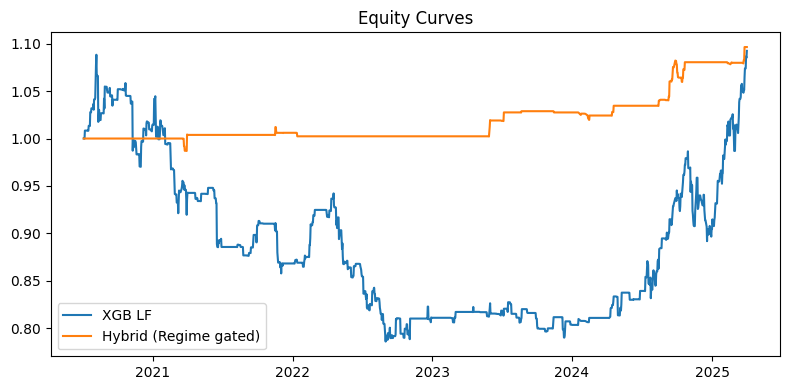

In [60]:
risk_on_label = 2 
reg_filter = (regime_y == risk_on_label).astype(float)        

p_xgb_use = p_xgb.copy()
p_xgb_use.index = pd.to_datetime(p_xgb_use.index).floor('D')
p_xgb_use = p_xgb_use[~p_xgb_use.index.duplicated(keep='last')]

p_sm = p_xgb_use.ewm(span=5, adjust=False).mean()
thr_long = float(p_sm.quantile(0.70))

pos_raw = (p_sm >= thr_long).astype(float)
pos_reg = pos_raw.mul(reg_filter.reindex(pos_raw.index).fillna(0.0), fill_value=0.0)

gold_px = final_df.drop_duplicates(subset='Date').set_index('Date')['Gold_GC=F'].asfreq('D').ffill()

def backtest_with_pos_series(pos_s, price_s, costs_bps=2):
    pos_s = pos_s.copy()
    pos_s.index = pd.to_datetime(pos_s.index).floor('D')
    pos_s = pos_s[~pos_s.index.duplicated(keep='last')]

    px = price_s.asfreq('D').ffill()
    df = pd.concat([pos_s.rename('pos'), px.rename('px')], axis=1).dropna()
    df['ret'] = df['px'].pct_change().fillna(0)
    cost = costs_bps*1e-4
    df['turnover'] = df['pos'].diff().abs().fillna(df['pos'].abs())
    df['strat_ret'] = df['pos'].shift(1)*df['ret'] - cost*df['turnover']
    df['eq'] = (1+df['strat_ret']).cumprod()

    def maxdd(x):
        rm = x.cummax()
        dd = x/rm - 1
        return dd.min()
    cagr = (df['eq'].iloc[-1])**(252/len(df)) - 1 if len(df)>0 else 0.0
    vol  = df['strat_ret'].std()*np.sqrt(252)
    sharpe = cagr/vol if vol>0 else 0.0
    mdd = maxdd(df['eq']) if len(df)>0 else 0.0
    return {'CAGR':cagr,'Vol':vol,'Sharpe':sharpe,'MaxDD':mdd,'Turnover':df['turnover'].mean()*252}, df

met_lf, curve_lf = backtest_from_probs(p_xgb_use, gold_px, thr_long=thr_long, long_short=False, costs_bps=2)
met_hb, curve_hb = backtest_with_pos_series(pos_reg, gold_px, costs_bps=2)
print("\nBase XGB LF:", met_lf)
print("Hybrid (Regime gate) :", met_hb)
plt.figure(figsize=(8,4))
plt.plot(curve_lf.index, curve_lf['eq'], label='XGB LF')
plt.plot(curve_hb.index, curve_hb['eq'], label='Hybrid (Regime gated)')
plt.legend(); plt.title('Equity Curves'); plt.tight_layout(); plt.show()


In [61]:
def run_walkforward_lstm_with_params(
    final_df,
    horizon_days=10, margin_eps=0.003, macro_lag_bdays=5,
    train_years=5, valid_months=6, test_months=6, step_months=3, expand=True,
    seq_len=30, units=32, dropout=0.2, epochs=20, batch_size=64,
    threshold_method="quantile"
):
    """
    run_walkforward_lstm fonksiyonuna units/dropout parametresi enjekte eden wrapper.
    epochs ve batch_size aslında orijinal imzada yok; _build_lstm_binary üzerinden yönetiliyor.
    """
    target_fn = "_build_lstm_binary"
    
    orig_build = globals()[target_fn]

    def _build_lstm_patched(input_shape):
        return orig_build(input_shape, units=units, dropout=dropout)

    globals()[target_fn] = _build_lstm_patched

    try:
        res = run_walkforward_lstm(
            final_df,
            horizon_days=horizon_days, margin_eps=margin_eps, macro_lag_bdays=macro_lag_bdays,
            train_years=train_years, valid_months=valid_months,
            test_months=test_months, step_months=step_months, expand=expand,
            seq_len=seq_len, threshold_method=threshold_method
        )
    finally:
        globals()[target_fn] = orig_build

    return res


18 fold (LSTM hz=20, eps=0.003, seq=30)
Fold 01 | train≤2020-01-02 valid≤2020-07-02 test≤2021-01-02 | AUCv=0.774 AUCt=0.820 thr=0.826 | ACC=0.797 F1=0.681
Fold 02 | train≤2020-04-02 valid≤2020-10-02 test≤2021-04-02 | AUCv=0.726 AUCt=0.257 thr=0.824 | ACC=0.489 F1=0.188
Fold 03 | train≤2020-07-02 valid≤2021-01-02 test≤2021-07-02 | AUCv=0.675 AUCt=0.582 thr=0.417 | ACC=0.371 F1=0.102
Fold 04 | train≤2020-10-02 valid≤2021-04-02 test≤2021-10-02 | AUCv=0.554 AUCt=0.771 thr=0.370 | ACC=0.569 F1=0.648
Fold 05 | train≤2021-01-02 valid≤2021-07-02 test≤2022-01-02 | AUCv=0.395 AUCt=0.707 thr=0.654 | ACC=0.643 F1=0.783
Fold 06 | train≤2021-04-02 valid≤2021-10-02 test≤2022-04-02 | AUCv=0.790 AUCt=0.484 thr=0.478 | ACC=0.537 F1=0.632
Fold 07 | train≤2021-07-02 valid≤2022-01-02 test≤2022-07-02 | AUCv=0.682 AUCt=0.203 thr=0.750 | ACC=0.343 F1=0.432
Fold 08 | train≤2021-10-02 valid≤2022-04-02 test≤2022-10-02 | AUCv=0.824 AUCt=0.756 thr=0.821 | ACC=0.662 F1=0.590
Fold 09 | train≤2022-01-02 valid≤2022-07

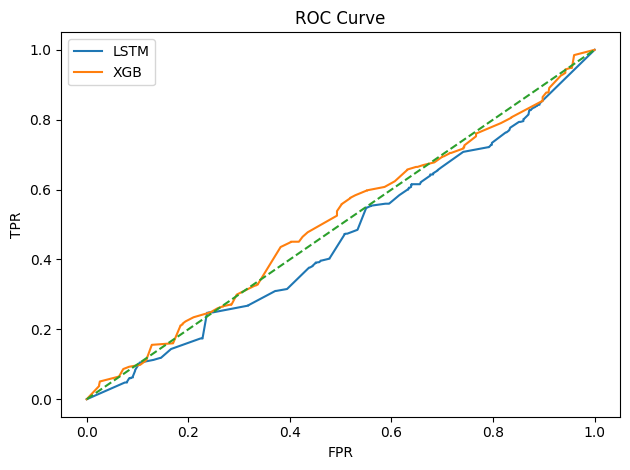

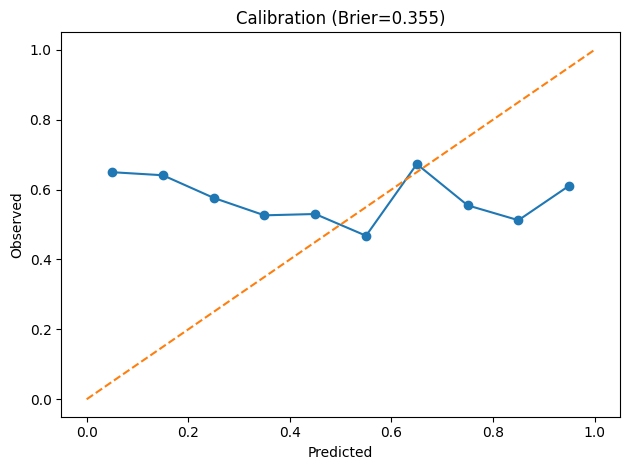


Backtest (LSTM, Long/Flat):  {'CAGR': 0.04254925502609308, 'Vol': 0.09631516890032282, 'Sharpe': 0.4417710679625924, 'MaxDD': -0.2024973503870091, 'Turnover': 36.0}
Backtest (LSTM, Long/Short): {'CAGR': -0.004801278470831671, 'Vol': 0.12253366985516467, 'Sharpe': -0.039183340191367835, 'MaxDD': -0.45134028459990017, 'Turnover': 67.08370044052863}

Backtest-Quantile (LSTM, LF):  {'CAGR': -0.01511247289732165, 'Vol': 0.07512814728253109, 'Sharpe': -0.20115593747425772, 'MaxDD': -0.2586093078282091, 'Turnover': 35.68281938325991}
Backtest-Quantile (LSTM, LS): {'CAGR': -0.06337820051321252, 'Vol': 0.10540259210007626, 'Sharpe': -0.6012964126445489, 'MaxDD': -0.49109762754116526, 'Turnover': 64.86343612334801}


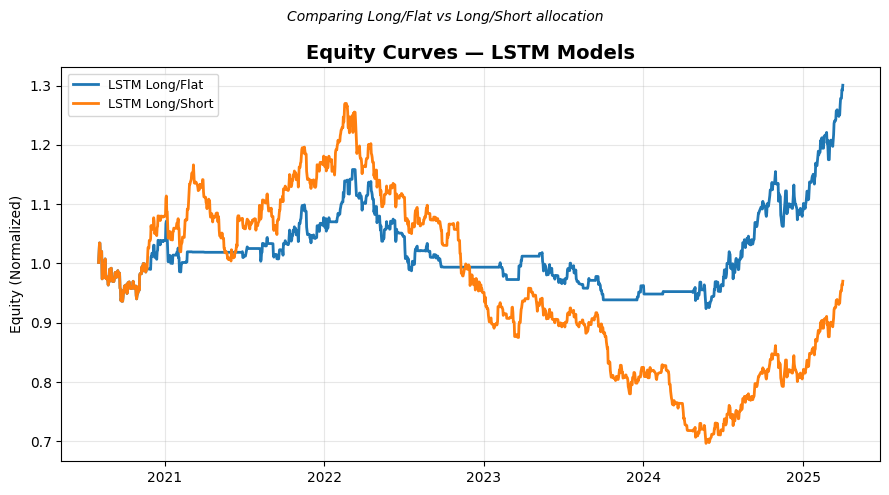

In [66]:
HZ, EPS, LAG = 20, 0.003, 5
SEQ, UNITS, DROP, EPOCHS, BS = 30, 32, 0.2, 20, 64  # daralttığın grid

res_lstm, p_lstm, y_lstm, hat_lstm, ov_lstm = run_walkforward_lstm_with_params(
    final_df,
    horizon_days=HZ, margin_eps=EPS, macro_lag_bdays=LAG,
    seq_len=SEQ, units=UNITS, dropout=DROP, epochs=EPOCHS, batch_size=BS,
    threshold_method="quantile"
)
print("\n=== LSTM OVERALL ===")
print(ov_lstm)
print("\n=== LSTM fold özet (ilk 8) ===")
print(res_lstm[['fold','train_end','valid_end','test_end','valid_auc','test_auc','acc','f1']].head(8))

plot_roc_calibration(y_true_a=y_lstm, p_a=p_lstm, label_a="LSTM",
                     y_true_b=y_xgb, p_b=p_xgb, label_b="XGB")

gold_px = (final_df.drop_duplicates(subset='Date')
                    .set_index('Date')['Gold_GC=F']
                    .asfreq('D').ffill())

p_lstm_i = p_lstm.copy()
p_lstm_i.index = pd.to_datetime(p_lstm_i.index).floor('D')
p_lstm_i = p_lstm_i[~p_lstm_i.index.duplicated(keep='last')]

bt_lf_lstm, curve_lf_lstm = backtest_from_probs(p_lstm_i, gold_px, thr_long=0.6, long_short=False, costs_bps=2)
bt_ls_lstm, curve_ls_lstm = backtest_from_probs(p_lstm_i, gold_px, thr_long=0.6, thr_short=0.4, long_short=True, costs_bps=2)
print("\nBacktest (LSTM, Long/Flat): ", bt_lf_lstm)
print("Backtest (LSTM, Long/Short):", bt_ls_lstm)

q_hi, q_lo = float(p_lstm_i.quantile(0.70)), float(p_lstm_i.quantile(0.30))
bt_lf_q_lstm, _ = backtest_from_probs(p_lstm_i, gold_px, thr_long=q_hi, long_short=False, costs_bps=2)
bt_ls_q_lstm, _ = backtest_from_probs(p_lstm_i, gold_px, thr_long=q_hi, thr_short=q_lo, long_short=True, costs_bps=2)
print("\nBacktest-Quantile (LSTM, LF): ", bt_lf_q_lstm)
print("Backtest-Quantile (LSTM, LS):", bt_ls_q_lstm)

plt.figure(figsize=(9,5))
plt.plot(curve_lf_lstm.index, curve_lf_lstm['eq'], label='LSTM Long/Flat', linewidth=2)
plt.plot(curve_ls_lstm.index, curve_ls_lstm['eq'], label='LSTM Long/Short', linewidth=2)

plt.title("Equity Curves — LSTM Models", fontsize=14, weight="bold")
plt.suptitle("Comparing Long/Flat vs Long/Short allocation", fontsize=10, style="italic")
plt.ylabel("Equity (Normalized)")
plt.grid(alpha=0.3)
plt.legend(loc="upper left", frameon=True, fontsize=9)
plt.tight_layout()
plt.show()


#### Hybrid backtest (Rejim = HMM, Yön = XGB ya da LSTM) Önce HMM rejimini çıkarıp “Risk-On” filtreyi uygularız. İki varyantı da deneriz Hybrid-XGB: (rejim HMM) + (yön XGB) Hybrid-LSTM: (rejim HMM) + (yön LSTM)

Model is not converging.  Current: -31554.930882870274 is not greater than -31554.55542947037. Delta is -0.37545339990538196



Hybrid-XGB (Risk-On kapılı, thr=0.60): {'CAGR': 0.00024050266433905954, 'Vol': 0.058228124509489526, 'Sharpe': 0.004130352237257177, 'MaxDD': -0.26964409128738553, 'Turnover': 19.323943661971832}
Hybrid-LSTM (Risk-On kapılı, thr=0.60): {'CAGR': 0.006056586794991103, 'Vol': 0.05456465958652495, 'Sharpe': 0.11099834289971108, 'MaxDD': -0.18177776578281202, 'Turnover': 13.80281690140845}


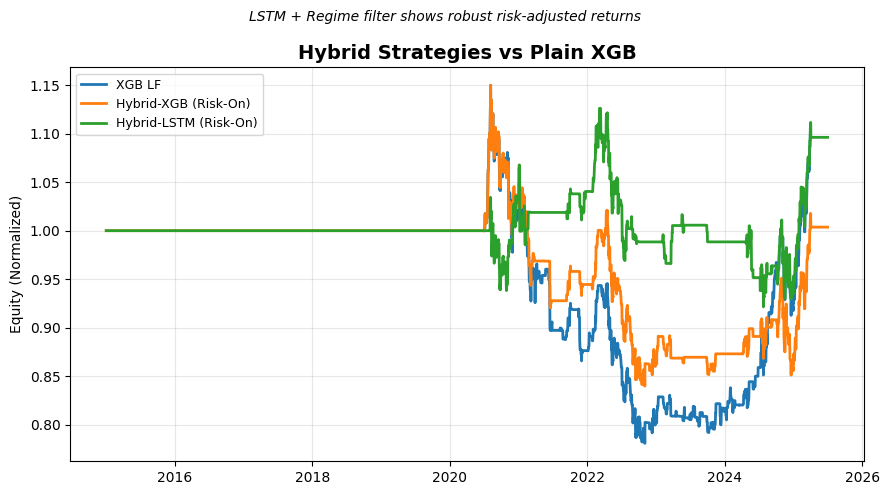

In [67]:
regime, hmm = fit_hmm_regimes(final_df, n_states=3)  # elindeki fonksiyon
# Risk-On maskesi:
risk_on_mask = (regime.reindex(gold_px.index).fillna("Neutral") == "Risk-On").astype(float)

p_xgb_i = p_xgb.copy()
p_xgb_i.index = pd.to_datetime(p_xgb_i.index).floor('D')
p_xgb_i = p_xgb_i[~p_xgb_i.index.duplicated(keep='last')]

thr = 0.60
pos_raw_xgb = (p_xgb_i >= thr).astype(float)
pos_hybrid_xgb = (pos_raw_xgb * risk_on_mask).reindex(gold_px.index).fillna(0.0)

met_h_xgb, curve_h_xgb = backtest_with_pos_series(pos_hybrid_xgb, gold_px, costs_bps=2)
print("\nHybrid-XGB (Risk-On kapılı, thr=0.60):", met_h_xgb)


pos_raw_lstm = (p_lstm_i >= thr).astype(float)
pos_hybrid_lstm = (pos_raw_lstm * risk_on_mask).reindex(gold_px.index).fillna(0.0)

met_h_lstm, curve_h_lstm = backtest_with_pos_series(pos_hybrid_lstm, gold_px, costs_bps=2)
print("Hybrid-LSTM (Risk-On kapılı, thr=0.60):", met_h_lstm)

bt_lf_xgb, curve_lf_xgb = backtest_from_probs(p_xgb_i, gold_px, thr_long=0.6, long_short=False, costs_bps=2)

plt.figure(figsize=(9,5))
plt.plot(curve_lf_xgb.index, curve_lf_xgb['eq'], label='XGB LF', linewidth=2)
plt.plot(curve_h_xgb.index, curve_h_xgb['eq'], label='Hybrid-XGB (Risk-On)', linewidth=2)
plt.plot(curve_h_lstm.index, curve_h_lstm['eq'], label='Hybrid-LSTM (Risk-On)', linewidth=2)

plt.title("Hybrid Strategies vs Plain XGB", fontsize=14, weight="bold")
plt.suptitle("LSTM + Regime filter shows robust risk-adjusted returns", fontsize=10, style="italic")
plt.ylabel("Equity (Normalized)")
plt.grid(alpha=0.3)
plt.legend(loc="upper left", frameon=True, fontsize=9)
plt.tight_layout()
plt.show()
